In [23]:
pip install prince


Note: you may need to restart the kernel to use updated packages.


In [24]:
!pip install geopandas

In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
from prince import mca
import prince 
import requests
import io

In [148]:
file_path ="https://minio.lab.sspcloud.fr/emile/Deep_seas/20177113_DS_D3.1-SEAS2-dataset-2022_rev1.csv"
df = pd.read_csv(file_path, sep=';', encoding='utf-8', low_memory=False, na_values=" ", decimal=',')
df.describe() 


,Respondent_Serial,INTRO_CATI,INTRO_CAWI,SD_1,SD_2,QSD_2,SD_3,REG_CAT,REG,REG_quota,...,cbsqf_alc,c1cbsqf_alc,cRSOD_1a,SD_20_income_type,SD_20,SD_20A,SD_20B,SD_20C,sd_20month,inc_mth
count,5.601400e+04,8810.0,47204.0,56014.000000,56014.000000,56014.000000,56014.000000,1516.000000,56014.000000,56014.000000,...,55483.000000,55483.000000,47091.000000,47831.000000,2.974800e+04,16068.000000,1.270800e+04,4.245600e+04,4.245600e+04,4.245600e+04
mean,5.782639e+08,1.0,1.0,1.518781,41.056486,2.073624,16.854197,1.509235,297.832167,1668.286946,...,777.543117,763.731402,158.253150,0.280508,4.147129e+05,1811.889283,6.781278e+04,3.108782e+05,4.172756e+04,1.965886e+04
std,1.637197e+09,0.0,0.0,0.501969,12.820770,0.872051,10.191840,0.982645,187.392295,997.947320,...,1922.011090,1740.420721,134.101578,0.449252,1.872299e+06,3628.254842,1.784258e+05,1.578282e+06,1.432824e+05,8.073478e+04
min,1.900000e+01,1.0,1.0,1.000000,18.000000,1.000000,1.000000,1.000000,1.000000,101.000000,...,-1.000000,-1.000000,0.000000,0.000000,1.875000e+02,0.000000,1.875000e+02,1.875000e+02,1.250000e+02,1.250000e+01
25%,1.737850e+04,1.0,1.0,1.000000,30.000000,1.000000,8.000000,1.000000,114.000000,801.000000,...,27.625000,27.625000,48.500000,0.000000,2.000000e+03,79.000000,1.950500e+03,2.000000e+03,1.500042e+03,6.944444e+02
50%,3.636400e+04,1.0,1.0,2.000000,41.000000,2.000000,16.000000,1.000000,325.000000,1606.000000,...,195.000000,195.000000,107.600000,0.000000,4.500000e+03,169.000000,5.250000e+03,4.500500e+03,3.000500e+03,1.400000e+03
75%,5.647075e+04,1.0,1.0,2.000000,52.000000,3.000000,26.000000,2.000000,411.000000,2502.000000,...,727.420000,727.420000,246.400000,1.000000,3.000000e+04,338.000000,3.499950e+04,3.250050e+04,1.125000e+04,4.500000e+03
max,7.600002e+09,1.0,1.0,3.000000,64.000000,3.000000,43.000000,4.000000,1477.000000,3409.000000,...,63119.632500,18250.000000,400.000000,1.000000,1.656000e+07,9999.000000,1.500000e+06,1.656000e+07,1.380000e+06,1.380000e+06


In [27]:
df.shape

(56014, 191)

**Sélection des variables**

In [262]:
variables = ["COUNTRY","SD_1", "SD_2", "SD_4","SD_6", "SD_7", 
             "SD_8","SD_9", "SD_10", "sd_20month" ,"social_class",
             "bsqf_alc", "f_1b", "RSOD_5a", "RSOD_5b", "RSOD_5c", "cbsqf_beer", "cbsqf_spir", "cbsqf_wine",
             "RSOD_5d", "RSOD_2b", "RSOD_7b", "CH_1", "WB_1", "WB_2", "WB_3"]
data = df[variables]



Explication de la sélection: Nous avons garder l'ensemble des variables qui faisaient sens du point de vue de la réponse à notre problématique.
La plupart des variables non sélectionnées sont redondantes avec celles ici,
(notamment des variables quantitatives qui avaient été recodées à partir des variables catégorielles que nous incluons ici).
Toutes les variables recueillant l'opinion des interrogés ont été exclues pour leur difficulté potentielle à être traiter, 
par exemple: AP_9: Printed warnings about alcohol-related harm should be displayed on alcohol packaging ? Strongly agree, somewhat agree,...


In [29]:
data.dtypes

COUNTRY           int64
SD_1              int64
SD_2              int64
SD_4              int64
SD_6              int64
SD_7            float64
SD_8              int64
SD_9              int64
SD_10             int64
sd_20month      float64
Demo_Empl       float64
social_class      int64
bsqf_alc        float64
f_1b              int64
RSOD_5a         float64
RSOD_5b         float64
RSOD_5c         float64
cbsqf_beer      float64
cbsqf_spir      float64
cbsqf_wine      float64
RSOD_5d         float64
RSOD_2b         float64
RSOD_7b         float64
CH_1              int64
WB_1              int64
WB_2              int64
WB_3              int64
dtype: object

**Nettoyage de la base**

In [266]:
import importlib
import clean_data as cld
#importlib.reload(cld)

In [150]:
#Les pays de la base sont codés de 10 à 43, on les associe à leur nom via le dictionnaire country_mapping de clean_data
if pd.api.types.is_numeric_dtype(data['COUNTRY']):
    data['COUNTRY'] = data['COUNTRY'].map(cld.country_mapping)
else:
    print("Le mapping a déjà été effectué, on ne fait rien.") #Pour éviter de remplacer par NA si on exécute ce code 2 fois par erreur

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_15204\1535886202.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['COUNTRY'] = data['COUNTRY'].map(cld.country_mapping)


Le questionnaire de Deepseas précise que le salaire mensuel sd_20month a été fourni en monnaie locale par les répondants mais le code book ne précise pas si la variable a été remise dans la même unité monétaire ou non. Regardons la distribution des revenus par pays ci-dessous:

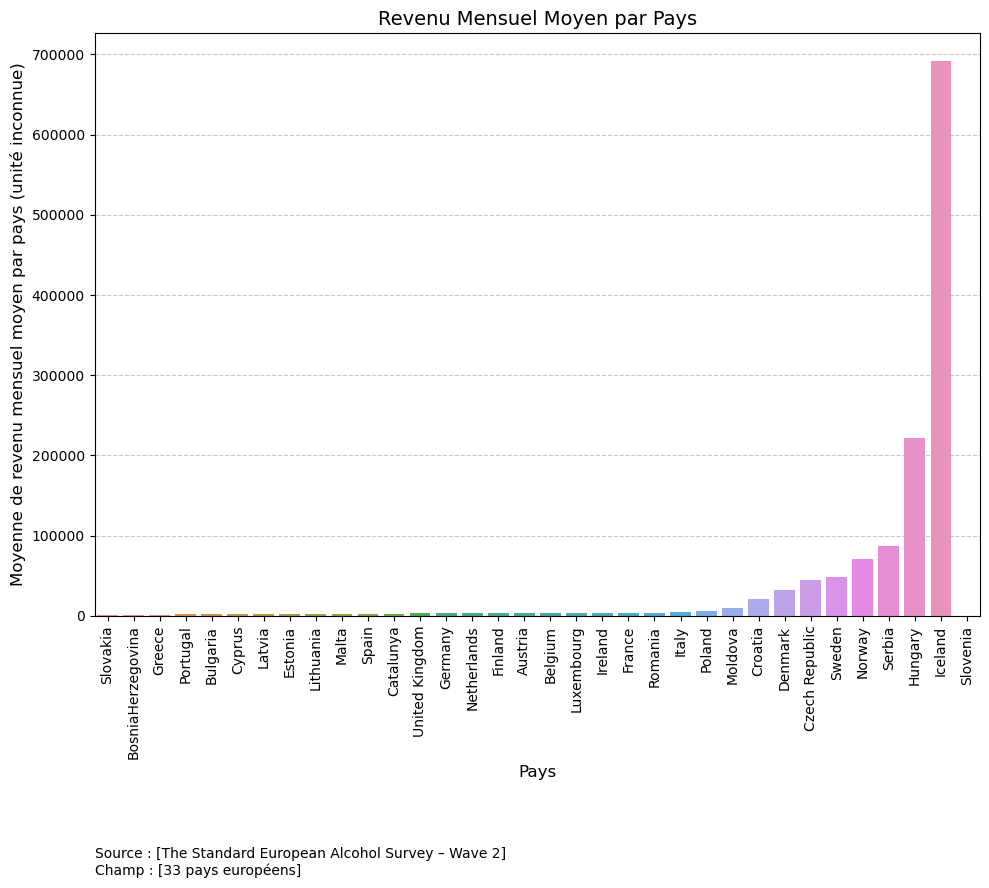

In [32]:
cld.barplot_bycntry(data)

La variable sd_20month du salaire mensuel est restée en monnaie local puisque les pays hors zone euro qui ont presque tous une monnaie plus faible que l'euro se retrouvent à avoir les salaires mensuels les plus élevés, alors que ce ne sont pas nécessairement ceux où le niveau de vie est le plus élevé. On notera que les valeurs manquent pour la Slovénie dû au fait que le questionnaire slovène n'a pas précisé si les répondants devaient donner leur salaire mensuel ou annuel, les sondeurs ont donc supprimer les données de salaire pour ce pays. 

Les entretients pour construire cette base de données ayant été menés en 2019 et 2020, nous choisissons de convertir tous les salaires en euros selon les valeurs publiées au journal officiel de l'Union Européenne pour le 2 janvier 2020. Cette date qui précède la crise Covid peut permettre d'éviter des erreurs d'interprétation des niveaux de vie, la crise Covid ayant fait significativement fluctuer les taux de change, faisant notamment s'apprécier l'euro par rapport à certaines monnaies début 2020 (couronne tchèque, islandaise, etc.).


In [151]:
# On crée une variable avec les taux de changes de 2020 
data['EXCHANGE_RATE_TO_EUR'] = data['COUNTRY'].map(cld.conversion_rates)

# Appliquer la conversion à la variable 'sd_20month'
data['sd_20month_EUR_2020'] = data['sd_20month'] * data['EXCHANGE_RATE_TO_EUR']

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_15204\3813934418.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['EXCHANGE_RATE_TO_EUR'] = data['COUNTRY'].map(cld.conversion_rates)
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_15204\3813934418.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sd_20month_EUR_2020'] = data['sd_20month'] * data['EXCHANGE_RATE_TO_EUR']


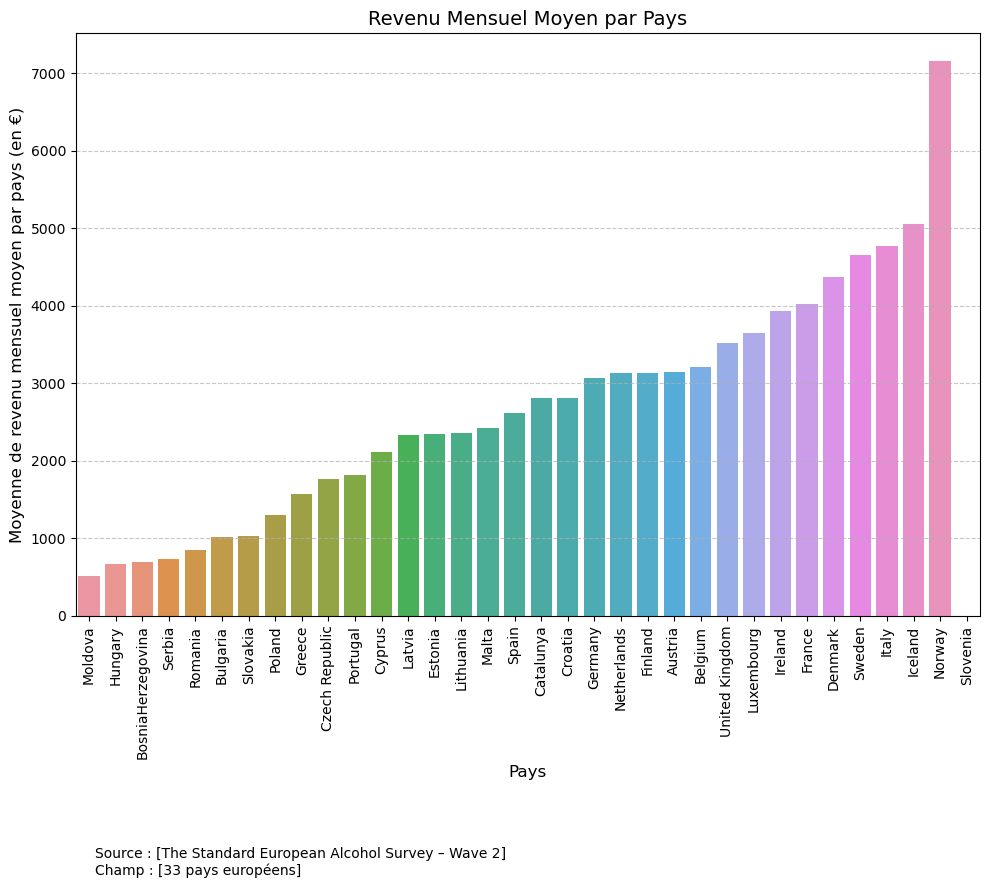

In [34]:
# Barplot des salaires mensuels moyens convertis en €
cld.barplot_bycntry(data, colonne_y='sd_20month_EUR_2020',y_name= "revenu mensuel moyen par pays (en €)")


On remarque que cette distribution des revenus n'est pas toujours cohérente avec la réalité des distributions moyennes de revenus entre les pays européens. Par exemple, le revenu moyen déclaré par les italiens interrogés est supérieur à celui des irlandais interrogés, ce qui n'est pas vrai dans la population totale. Cela témoigne soit d'un biais déclaratif plus élevé dans certains pays que d'autres, soit d'un biais de sélection du fait que les personnes interrogées dans certains pays (en Italie par exemple) font partie d'une partie plus favorisée économiquement de la population de leur pays que les individus interrogés dans d'autres pays (par exemple l'Irlande). Le cas échéant, cela signifie que les personnes interrogées ne sont pas équitablement répartis dans la distribution des revenus, dans certains pays du moins (ce que Kilian et Al. pointent du doigt dans leur papier "The socioeconomic profile of alcohol use in Europe: Findings
from a cross-sectional survey of 33 European countries" qui analyse Deepseas du point de vue européen).

NB: Les salaires extrêmement hauts de la Slovénie sont dû à un oubli de la part des sondeurs de préciser si le salaire était mensuel ou annuel dans les questions posées aux slovènes. On ne pourra donc pas utiliser ce pays pour notre étude.

On décide de créer également une nouvelle variable de salaire mensuel en euros PPA pour pouvoir comparer les pays selon leur pouvoir d'achat.
On liste ci-après les taux PPA donnés par Eurostat et la Banque Mondiale qui correspondent au Taux de change/ Indice des prix.

In [152]:
# Création d'un variable Valeurs brutes de parité (PPA) et conversion des salaires en euros PPA
data['PPA'] = data['COUNTRY'].map(cld.ppa_brut)
data['sd_20month_EUR_2020_PPA']= data['sd_20month'] / data['PPA']

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_15204\581596296.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['PPA'] = data['COUNTRY'].map(cld.ppa_brut)
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_15204\581596296.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sd_20month_EUR_2020_PPA']= data['sd_20month'] / data['PPA']


*Premier traitement des valeurs manquantes*

In [127]:
# Affiche le tableau des données manquantes par variable (en %)
stats_na = cld.tableau_na(data)
stats_na

Variable,Taux de manquants
COUNTRY,0.00%
SD_1,0.00%
SD_2,0.00%
SD_4,0.00%
SD_6,0.00%
SD_7,21.22%
SD_8,0.00%
SD_9,0.00%
SD_10,0.00%
sd_20month,24.20%


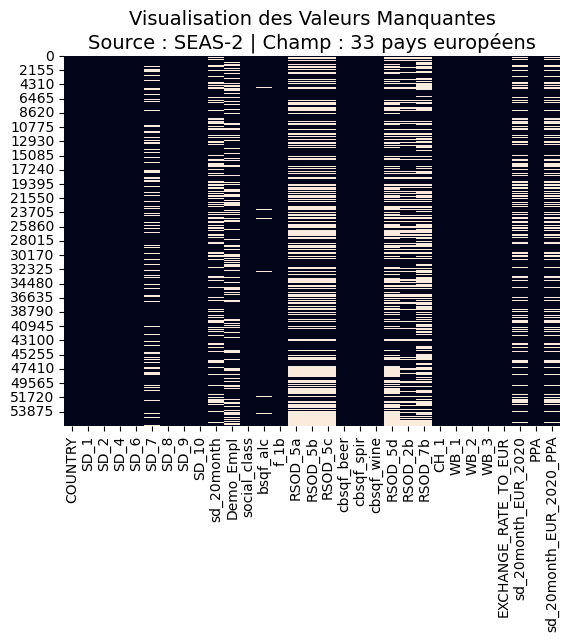

In [37]:
#version plus visuelle du tableau précédent
cld.visu_na(data)

Les variables présentant des valeurs manquantes dans des proportions potentiellement problématiques sont:
- SD_7: le nombre de mineur dans le foyer de l'individu (21% de NA)
- SD_20month : le revenu du ménage par mois (24% de NA)
- Demo_Empl: si temps partiel, temps plein ou autre (31% de NA)
- Les RSOD_5(a à d): les lieux de consommation d'alcool (46% de NA)
- RSOD_2b : Fréquence 4/6+ verres en nombre de jours par an (46% de NA) ;
- RSOD_7b : Fréquence 8/12+ verres en nombre de jours par an (50% de NA)

Nous les traiterons une par une par la suite.

*Traitement de bsqf_alc la consommation d'alcool pur par an et par individu en cl*

In [153]:
#pourcentages de valeurs manquantes pour la quantité d'alcool consommée dans les 12 derniers mois (en cl)
cld.tableau_na_pays(data, "bsqf_alc")

,bsqf_alc
COUNTRY,
Austria,0.018094
Belgium,0.009309
BosniaHerzegovina,0.004667
Bulgaria,0.002329
Catalunya,0.011873
Croatia,0.002663
Cyprus,0.008667
Czech Republic,0.006662
Denmark,0.012018


In [39]:
#Peu de valeurs manquantes dans la consommation d'alcool en cl d'alcool pur bsqf_alc (moins de 2% sauf Islande, Allemagne et Malte moins de 3.7%) 
# donc on peut supprimer les individus qui présentent des valeurs manquantes pour cette variable sans créer de biais de sélection.

data= data.dropna(subset=['bsqf_alc'])
sum(data['bsqf_alc'].isna())

0

*Les variables RSOD_5(a à d)*

In [154]:
variables = ['RSOD_5a', 'RSOD_5b', 'RSOD_5c', 'RSOD_5d']

#Pourcentage d'observations où TOUTES les variables RSOD_5(a à d) sont manquantes
pourcentage_observations_manquantes_communes = data[variables].isna().all(axis=1).mean()

print(f"Nombre d'observations où toutes les variables sont manquantes : {pourcentage_observations_manquantes_communes}")

Nombre d'observations où toutes les variables sont manquantes : 0.4565287249616167


Les valeurs manquantes des RSOD_5(a à d) sont les mêmes, donc quand on ne connaît pas la récurrence de consommation d'alcool dans un lieu, on ne la connaît pour aucun. Ces variables présentent un très grand pourcentage de valeurs manquantes (46%) et ne sont pas évoqués dans la littérature que nous avons étudié comme déterminant d'un profil de consommateur d'alcool, nous décidons de ne pas les compléter et d'étudier leur rôle seulement au travers de quelques statistiques descriptives par pays.

Puisque ces variables ne sont pas complémentaires en termes d'individus répondants, qu'il y a plus de 45% de valeurs manquantes et que nous ne les avons trouvé comme typiques de certains consommateurs d'alcool dans aucune étude que nous avons lues, nous décidons de ne pas les étudier et de les retirer de la base pour le traitement.

In [155]:
# Identification et suppression des colonnes RSOD_5(a à d)
cdrop = ["RSOD_5a", "RSOD_5b", "RSOD_5c", "RSOD_5d"]
data = data.drop(columns=cdrop)

print(f"Colonnes supprimées : {cdrop}")

Colonnes supprimées : ['RSOD_5a', 'RSOD_5b', 'RSOD_5c', 'RSOD_5d']


*Traitement de RSOD_2b et RSOD_7b*

Variables catégorielles, respectivement la fréquence de consommation d'alcool supérieure à 4/6 verres et supérieure 8/12 verres.

In [41]:
#regardons si, de façon cohérente, les valeurs manquantes de RSOD_2b sont incluses dans celles de RSOD_7b qui en a davantage

print(f"NA uniquement dans 2b: {(data['RSOD_2b'].isna() & data['RSOD_7b'].notna()).sum()}")
print(f"NA uniquement dans 7b: {(data['RSOD_2b'].notna() & data['RSOD_7b'].isna()).sum()}")

NA uniquement dans 2b: 0
NA uniquement dans 7b: 13000


Donc si des valeurs sont manquantes dans RSOD_2b elles le sont bien aussi dans RSOD_7b, donc les gens qui n'ont pas répondu à leur fréquence de consommation d'alcool de 4/6+ verres n'ont pas non plus répondu à celle de 8/12+ verres .

Les RSOD_2b/7b sont codées comme suit (d'après le code book):

Frequency of
drinking 4/6+ (resp. 8/12+ )
drinks
- 1 = Every day
- 2 = 5-6 days a week
- 3 = 3-4 days a week
- 4 = 1 - 2 days a week
- 5 = 2 - 3 days a month
- 6 = One day in a month
- 7 = 6 - 11 days a year
- 8 = 2 - 5 days a year
- 9 = a single day in the past 12 months
- 10 = I did not drink in the past 12 months



Comme RSOD_7b a 50% de valeurs manquantes, on décide de l'abandonner pour ne garder que RSOD_2b qui en a 27%. On retiendra que, même si RSOD_7b est inclus dans RSOD_2b, on perd tout de même un peu d'information sur les alcoolisations ponctuelles importantes.

In [42]:
#Problème: On a remarqué en ouvrant la base sur excel (ça n'est donc pas une erreur d'interprétation des séparateurs) qu'il y a à la fois des 0 et des NA pour ces variables
#Alors que ce sont des catégorielles sans catégories 0 D'APRES LE CODEBOOK
#Comptons le nombre de 0 et de valeurs manquantes pour RSOD_2b
print(f"nombre de d'individus ayant RSOD_2b = 0: {data.loc[data['RSOD_2b']==0,'RSOD_2b'].count()}",
f", nombre de valeurs manquantes pour RSOD_2b: {data['RSOD_2b'].isna().sum()}")


nombre de d'individus ayant RSOD_2b = 0: 5286 , nombre de valeurs manquantes pour RSOD_2b: 14650


In [43]:
# Le codebook pourrait-il se tromper ?
# Essayons de voir combien d'individus correspondent à chaque code catégoriel de 1 à 10 possible:
print(data['RSOD_2b'].value_counts(dropna=False).sort_index())

RSOD_2b
0.0     5286
1.0      939
2.0      963
3.0     2597
4.0     4244
5.0     5590
6.0     3055
7.0     4499
8.0     6383
9.0     7277
NaN    14650
Name: count, dtype: int64


Il n'y a pas d'observation codée 10, il est cohérent de penser que le code book contient une erreur et que c'est le code 0 qui correspond à "I did not drink in the past 12 months [4/6+ drinks]" et non pas le code 10. 
Pour le vérifier, on va essayer de voir si les individus codés 0 sont bien ceux codés 10 dans le code book et si les codes des autres catégories sont restés inchangés ou non. Pour cela, on utilise la variable de fréquence de consommation d'alcool f_1b qui n'est pas un excellent proxy de RSOD_2b la fréquence de consommation de plus de 4/6 verres mais qui est le meilleur que nous ayons.

Rappel:codage de f_1b

generic
frequency of
drinking
- 1 = Every day
- 2 = 5-6 days a week
- 3 = 3-4 days a week
- 4 = 1 - 2 days a week
- 5 = 2 - 3 days a month
- 6 = One day in a month
- 7 = 6 - 11 days a year
- 8 = 2 - 5 days a year
- 9 = a single day in the past 12 months
- 10 = I did not drink but I drank earlier
- 11 = I never drank in my life

In [44]:
#On regarde quelle est la distribution de la variable f_1b
print(data['f_1b'].value_counts(dropna=False).sort_index())

f_1b
1      3703
2      4461
3      5614
4     13722
5      8881
6      3581
7      4341
8      4583
9      1311
10     2399
11     2887
Name: count, dtype: int64


In [45]:
print(f"Le nombre d'individus où RSOD_2b=0 et f_1b=10 ou 11 est : {data.loc[(data['RSOD_2b']==0) & ((data['f_1b'] == 10) |  (data['f_1b'] == 11)), 'RSOD_2b'].count()}",
f", Le nombre d'individus ou RSOD_2b=0 est {data['RSOD_2b'].value_counts(dropna=False)[0]}")

Le nombre d'individus où RSOD_2b=0 et f_1b=10 ou 11 est : 5286 , Le nombre d'individus ou RSOD_2b=0 est 5286


Les individus ayant n'ayant jamais consommé d'alcool dans les 12 derniers mois ou durant toute leur vie (catégorie 10 et 11 de f_1b) sont biens les mêmes qui ont RSOD_2b=0.
Le code 10 est bien devenu 0.

Pour vérifier la concordances des codes 1 à 9 avec les labels du codebook, on crée une table de contingence entre RSOD_2b et f_1b.

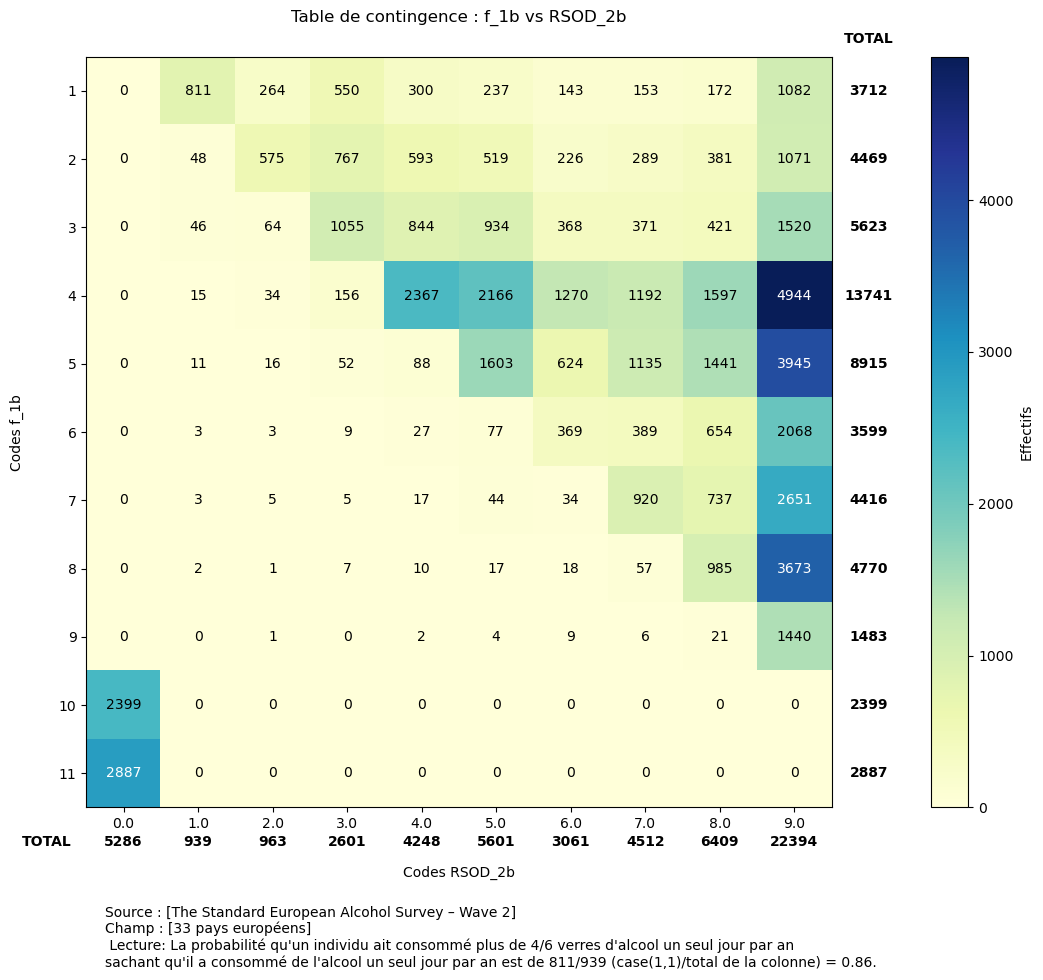

In [250]:

import importlib

import clean_data as cld

importlib.reload(cld)
# Table de contingence de la fréquance générique de consommation d'alcool 
# et de la fréquence de + de 4 verres
#NB: On est obligé de remplacer les RSOD_2b manquants par 0, ce qui est une limite à notre analyse
cld.trace_table_contingence(data)


Exemple d'interprétation: Tous les individus qui n'ont jamais consommé d'alcool dans leur vie ou durant les 12 derniers mois (f1_b=10 (2399 individus) ou 11(2887 individus)) n'ont jamais consommé plus de 4/6 verres d'alcool dans les 12 derniers mois. On valide de nouveau notre labelisation 0 = I did not drink in the past 12 month.


Puisque les codes 1 à 9 ont les mêmes labels pour les variables RSOD_2b et f_1b et que la diagonale de la table de contingence contient globalement dans les effectifs les plus élevés, en supposant une corrélation significative entre ces deux variables, on peut conclure que l'ordre  pas été décallé par rapport au codebook (hormis 10 évidemment). Si les codes avaient été décalés (par exemple si le 1 était devenu 2), nous verrions un décalage systématique de la diagonale, ce qui n'est pas le cas ici.

NB: On notera qu'on a remplacé les RSOD_2b manquants par 0 pour construire cette table ce qui est une légère limite à cette analyse.

Cela nous permet de confirmer assez sûrement l'hypothèse suivante:
La bonne distribution de RSOD_2b est:
Frequency of
drinking 4/6+ (resp. 8/12+ )
drinks
- 0 = I did not drink in the past 12 months
- 1 = Every day
- 2 = 5-6 days a week
- 3 = 3-4 days a week
- 4 = 1 - 2 days a week
- 5 = 2 - 3 days a month
- 6 = One day in a month
- 7 = 6 - 11 days a year
- 8 = 2 - 5 days a year
- 9 = a single day in the past 12 months


On peut par ailleurs utiliser cette table pour faire quelques commentaires sur la distribution statistique de RSOD_2b:


1. Dans nos deux échelles, plus le chiffre est petit, plus la fréquence est élevée (1 = tous les jours, 9 = 1 jour par an).

Or, on voit qu'il n'y a quasiment aucune observation dans la zone "sud-ouest" du tableau.

Ce qui est bon car cela signifie que personne n'a une fréquence de "forte consommation" (RSOD_2b) supérieure à sa fréquence de "consommation générale" (f_1b).Par exemple, personne n'est codé f_1b =4 (boit 1-2 fois/semaine) tout en étant RSOD_2b = 1 (boit 4/6+ verres tous les jours). C'est logiquement impossible, et la base respecte cela.

2. La distribution des "Binge Drinkers" (def: alcoolisation ponctuelle importante dans un temps très court, avec recherche d’ivresse)
Les points les plus denses pour les codes 1 à 9 se situent sur la diagonale ou légèrement à droite de celle-ci.

Exemple sur la ligne 4 (f_1b) : Le pic est au croisement avec la colonne 4 de RSOD_2b. Cela indique que les gens qui boivent 1 à 2 jours par semaine boivent souvent 4/6+ verres à chaque fois qu'ils consomment.

3. Les lignes 4 et 5 sont plus foncées:

Cela signifie que les consommateurs "intermédiaires" en terme de fréquence de consommation (entre 2 jours par semaine et deux jours par mois), consomment des quantités importantes d'alcool moins réguliérement que leur fréquence générale de consommation. Comme les effectifs sont relativement proches pour ces lignes, ces consommateurs intermédiaires ont des profils très hétérogènes dans leur attitude de "binge drinking", presque autant la pratiquent 2 à 3 fois par mois (2166 individus) que une fois par an (1895).

In [ ]:
# On compte les NA
print(f"Nombre de NA dans RSOD_2b : {data['RSOD_2b'].isna().sum()}")

Nombre de NA dans RSOD_2b : 14650


Avant de traiter ces valeurs manquantes, nous regardons si les répondants diffèrent selon s'ils ont répondu ou non à la question sur leur consommation excessive d'alcool.

In [ ]:
#création d'une variable valant 1 si RSOD_2b est manquante et 0 sinon
data['RSOD_2bisna'] = data['RSOD_2b'].isna().astype(int)

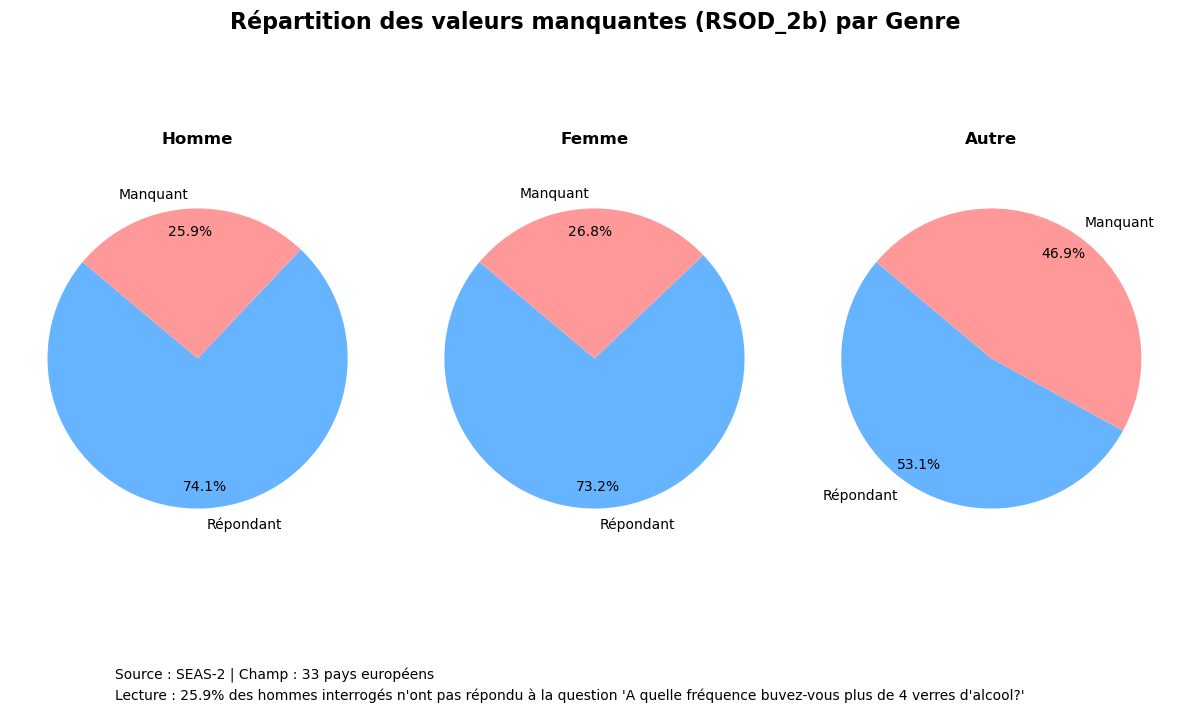

In [ ]:
# Diagrammes circulaires des parts de variables manquantes pour RSOD_2b selon le genre

labels_sexe = {1.0: "Homme", 2.0: "Femme", 3.0: "Autre"}
source_sexe = "Source : SEAS-2 | Champ : 33 pays européens\nLecture : 25.9% des hommes interrogés n'ont pas répondu à la question 'A quelle fréquence buvez-vous plus de 4 verres d'alcool?'"

cld.trace_camemberts_na(data, var_na='RSOD_2bisna', var_groupe='SD_1', 
                         dict_labels=labels_sexe, 
                         titre_general="Répartition des valeurs manquantes (RSOD_2b) par Genre",
                         source_texte=source_sexe)

On remarque que les personnes ne se déclarant ni homme, ni femme répondent presque deux fois moins à la question sur leur consommation ponctuelle excessive d'alcool. Les interrogés se déclarant comme homme ou femmme répondent dans les mêmes proportion (~26%).
On peut l'interpréter de deux manières: 
- soit certaines personnes sont réticentes à dévoiler toute sorte d'information, que ce soit le genre ou la consommation excessive d'alcool;
- soit les personnes qui négligent le questionnaire négligent en particulier ces deux questions;
- soit les personnes ne s'identifiant à aucun genre sont plus réticent à dévoiler leur consommation d'alcool.
DANGEREUX REVOIR

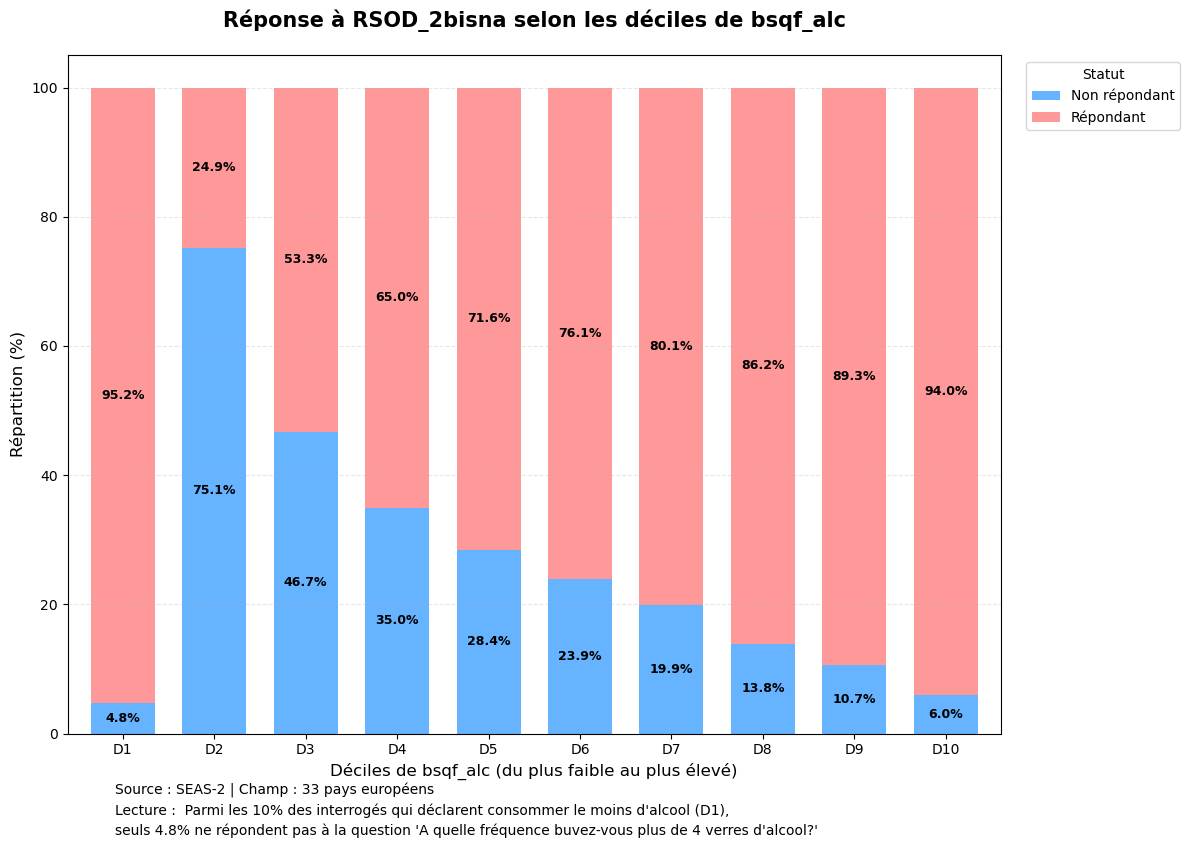

In [ ]:
# source et lecture spécifique
lecture = ("Source : SEAS-2 | Champ : 33 pays européens\n"
           "Lecture :  Parmi les 10% des interrogés qui déclarent consommer le moins d'alcool (D1),\n"
    "seuls 4.8% ne répondent pas à la question 'A quelle fréquence buvez-vous plus de 4 verres d'alcool?'")

# Crée barres empilées avec le % de répondants à la fréquence de consommation excessive d'alcool (4 verres et +) par déciles de la distribution de consommation d'alcool 
cld.trace_barplot_na(data, var_quanti='bsqf_alc', var_na='RSOD_2bisna', source_texte=lecture)

In [ ]:
seuils = data['bsqf_alc'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
print(seuils)

0.1       1.375
0.2      18.910
0.3      53.000
0.4     117.900
0.5     216.750
0.6     370.510
0.7     612.000
0.8    1061.150
0.9    2206.948
Name: bsqf_alc, dtype: float64


Relation en "U inversé" pour la non-réponse:
On observe que la part des "Non-répondants" (en bleu) n'est pas distribuée de manière uniforme :

Aux extrémités (D1 et D10) : Le taux de réponse est maximal. Les personnes qui consomment pas ou très peu d'alcool ou beaucoup répondent presque toutes à la question RSOD_2b.

On observe un pic de non-réponse, culminant à 75.1% pour le décile 2 et 46.7% pour le décile 3.

Proposition d'interprétation: (observation difficilement interprétable)

L'hypothèse explicative pourrait être que les gros consommateurs répondent plus facilement car ils identifient clairement ce comportement dans leur quotidien et sont donc plus enclins à déclarer une fréquence, même si elle est élevée. Et inversement pour les faibles consommateurs. 
Pour les très faibles consommateurs du 1er décile, ils consomment moins de 1.375 cl d'alcool par an, et savent donc qu'ils n'ont jamais consommé plus de 4 verres soit 40/7.89= 5 cl d'alcool. 

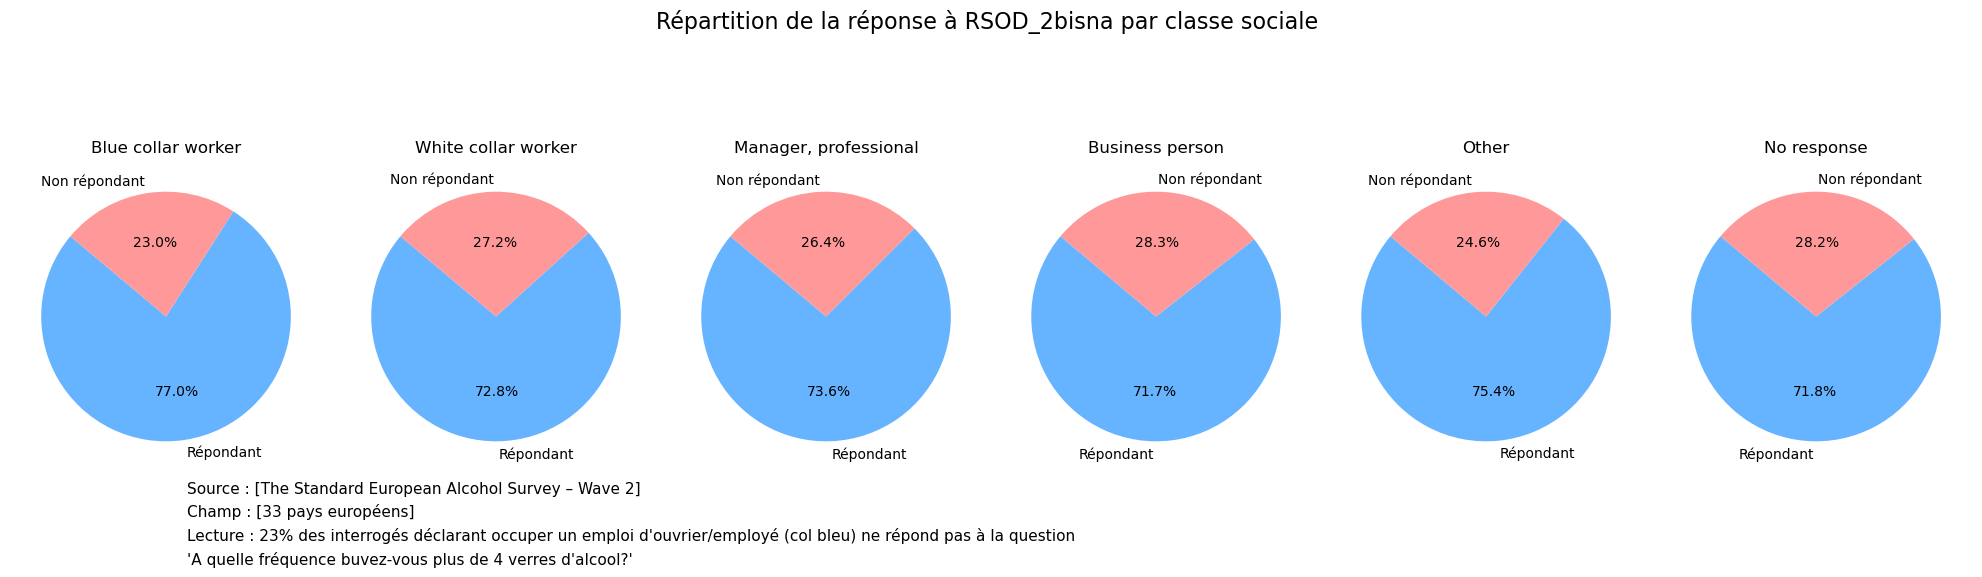

In [ ]:
#A mettre en annexe
class_labels = {
    1.00: "Blue collar worker",
    2.00: "White collar worker",
    3.00: "Manager, professional",
    4.00: "Business person",
    5.00: "Other",
    9.00: "No response"
}
rsod_labels = {0: 'Répondant', 1: 'Non répondant'}


classes = sorted(data['social_class'].unique())
fig, axes = plt.subplots(1, len(classes), figsize=(20, 6))

for i, s_class in enumerate(classes):
    subset = data[data['social_class'] == s_class]
    counts = subset['RSOD_2bisna'].value_counts().sort_index()
    
    axes[i].pie(
        counts, 
        labels=[rsod_labels.get(x, x) for x in counts.index],
        autopct='%1.1f%%', 
        startangle=140,
        colors=['#66b3ff', '#ff9999']
    )
    axes[i].set_title(class_labels.get(s_class, f"Classe {s_class}"))


source_texte = (
    "Source : [The Standard European Alcohol Survey – Wave 2]\n"
    "Champ : [33 pays européens]\n"
    "Lecture : 23% des interrogés déclarant occuper un emploi d'ouvrier/employé (col bleu) ne répond pas à la question\n"
    "'A quelle fréquence buvez-vous plus de 4 verres d'alcool?'"
)

fig.text(0.1, 0.05, source_texte, fontsize=11, ha='left', va='bottom', linespacing=1.6)


plt.suptitle("Répartition de la réponse à RSOD_2bisna par classe sociale", fontsize=16)
plt.tight_layout()
plt.show()

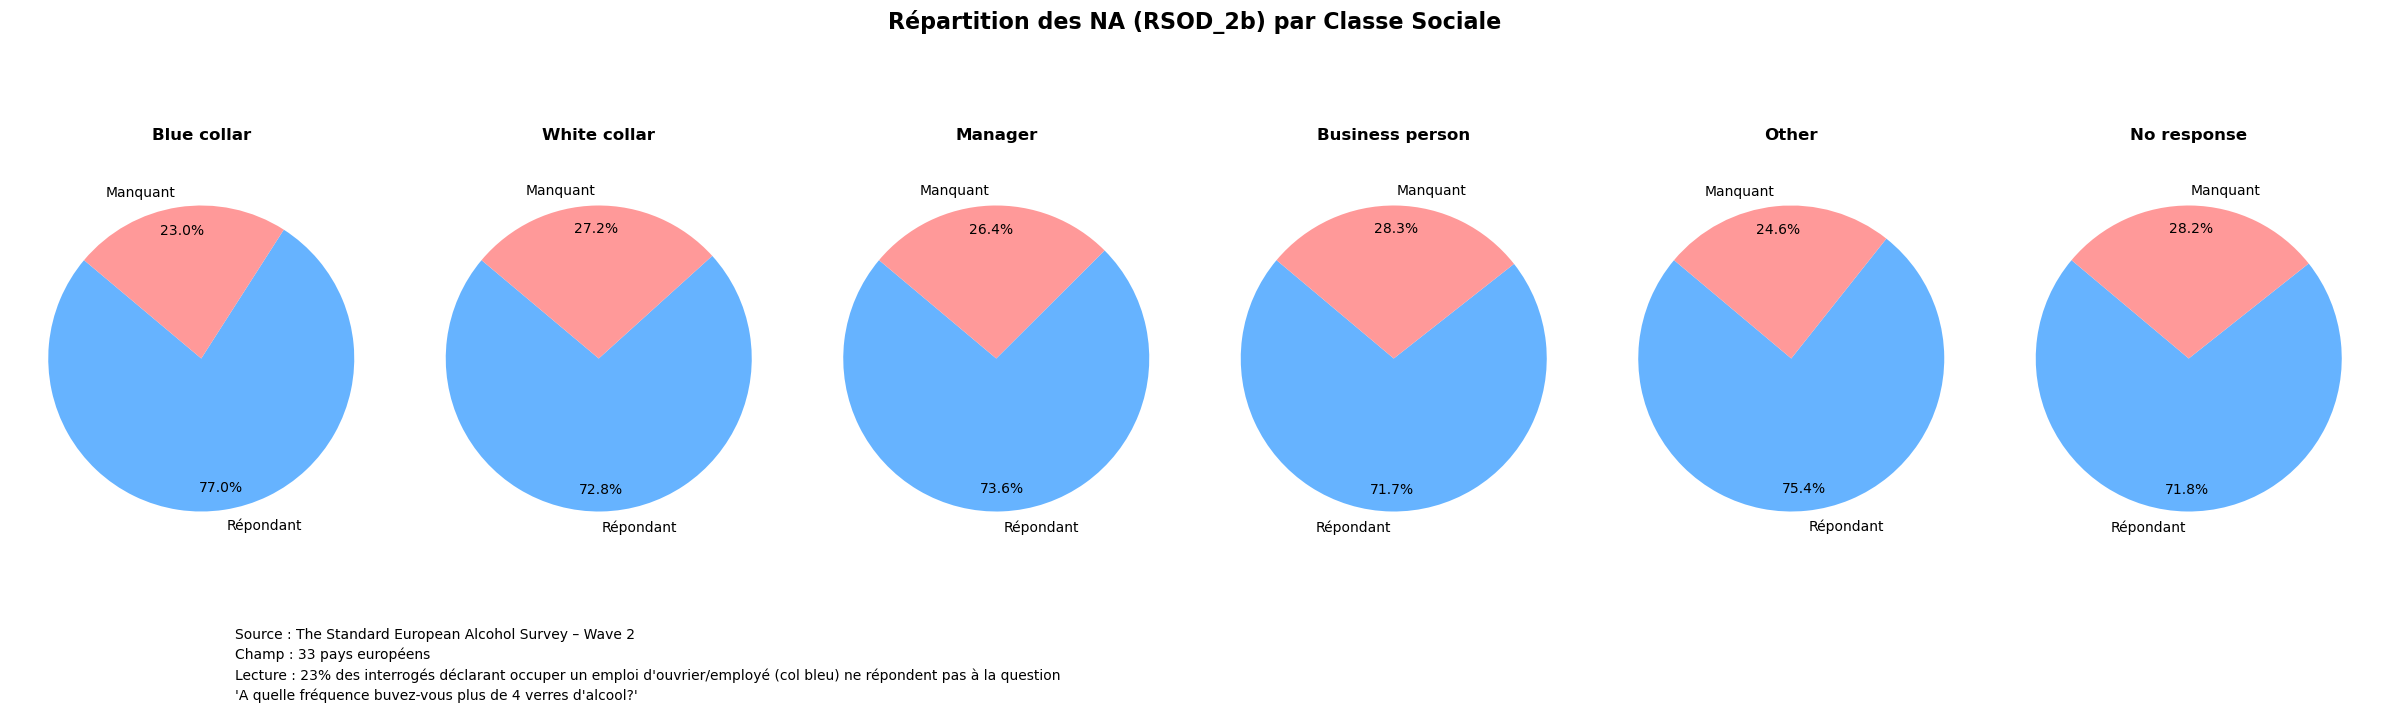

In [ ]:
labels_social = {1.0: "Blue collar", 2.0: "White collar", 3.0: "Manager", 
                 4.0: "Business person", 5.0: "Other", 9.0: "No response"}
source_social = (
    "Source : The Standard European Alcohol Survey – Wave 2\n"
    "Champ : 33 pays européens\n"
    "Lecture : 23% des interrogés déclarant occuper un emploi d'ouvrier/employé (col bleu) ne répondent pas à la question\n"
    "'A quelle fréquence buvez-vous plus de 4 verres d'alcool?'"
)
cld.trace_camemberts_na(data, var_na='RSOD_2bisna', var_groupe='social_class', 
                         dict_labels=labels_social, 
                         titre_general="Répartition des NA (RSOD_2b) par Classe Sociale",
                         source_texte=source_social)

On observe pas de différence significative dans les taux de non réponse pour RSOD_2b entre les différentes classes sociales.
Une séquence de diagrammes circulaires l'illustre en annexe

In [ ]:
# Ratio de valeurs manquantes par pays pour RSOD_2b
cld.tableau_na_pays(data, var="RSOD_2b")

,RSOD_2b
COUNTRY,
Austria,0.264232
Belgium,0.212081
BosniaHerzegovina,0.463496
Bulgaria,0.111741
Catalunya,0.333111
Croatia,0.172897
Cyprus,0.711500
Czech Republic,0.153588
Denmark,0.288732


Le pourcentage de valeurs manquantes pour RSOD_2b varie aussi selon les pays allant de  0.11 pour la Bulgarie à 0.71 pour Chypre. On notera que ces pays ont respectivement la plus forte et la plus faible consommation moyenne d'alcool en cl parmi les pays de la base. De manière générale, les pays qui consomment en moyenne le moins d'alcool ont aussi les plus hauts taux de non réponses et inversement.

Les personnes ayant RSOD_2b en valeur manquante ont donc bien un profil particulier, notamment en ce qui concerne leur consommation d'alcool. Les personnes qui consomment le moins d'alcool, répondent moins souvent à leur fréquence de consommation excessive. Ces valeurs manquantes engendrent donc un biais de sélection qu'il faudra prendre en compte dans nos interprétation. Ce qui est rassurrant pour notre analyse par pays, c'est que les pays qui consomment en moyenne le moins d'alcool ont bien aussi les plus hauts taux de non réponses et inversement. Si la baisse de la consommation de toute la population est proportionnelle à la hausse du nombre de valeur manquante, on peut se dire que le biais engendré sera environ le même peu importe les pays. A VERIFIER EMPIRIQUEMENT

*RSOD_2b - premiers traitement des valeurs manquantes*

Pour gérer les valeurs manquantes de RSOD_2b, on décide d'utiliser les variables de fréquence de consommation d'alcool par an (rf_1b) et de quantité consommée en gramme d'alcool pur (bsqf_alc).
Nous choisirons, comme les auteurs de la base le font dans leur conversions (cf. document "database guidelines" du github), de considérer qu'un verre d'alcool représente en moyenne 10 grammes d'alcool pur. 



Algorithme naïf :

0.  On prend toutes les valeurs manquantes de RSOD_2b
1.  diviser bsqf par masse volumique de l'alcool 0.789 kg/L
2.  diviser cela par rf_1b (recodé en quantitive en jour de consommation d'alcool par an)= on obtient la consommation moyenne en gramme d'alcool par jour où on a consommé de l'alcool sur l'année passée
3.  si celle-ci est inférieure à 40g (c'est à dire 4 verres), on met RSOD_2b = 0, sinon on met RSOD_2b= même valeur que fréquence générique rf1_b

On ne peut pas appliquer cet algorithme naïf qui réduirait la variance de consommation d'alcool des individus ayant une valeur manquante pour RSOD_2b à zéro.
Cependant, il y a deux cas de valeurs manquantes que l'on peut traiter facilement:
1) les individus qui ont consommé moins de 40g (soit 4 verres) d'alcool pur dans l'année et auxquels on peut attribuer RSOD_2b=0;
2) les individus qui ont consommé une seule fois par an plus de 40g d'alcool pur auxquels on peut attribuer RSOD_2b=9;

Pour le reste des valeurs manquantes sur cette variable, nous utiliserons la méthode d'imputation par "le plus proche voisin" après avoir sélectionner nos pays d'intérêt.

In [ ]:
# 1
# On regarde le nombre d'individu qui consomme moins de 40g par an soit 4 verre d'alcool selon notre critère de conversion, 
# ceux là sont forcément dans la catégorie 0 de RSOD_2b

print(len(data.loc[data['RSOD_2b'].isna() & (data['bsqf_alc'] < 40/7.89)])) # On divise par la masse volumique de l'alcool pur en gramme/cl car bsqf_alc est en cl

#On remplace ces valeurs manquantes de RSOD_2b par 0 dans une nouvelle variable RSOD_2bcorrected
data['RSOD_2bcorrected'] =data['RSOD_2b'].copy()
data.loc[data['RSOD_2b'].isna() & (data['bsqf_alc'] < 40/7.89),'RSOD_2bcorrected'] = 0

1591


In [ ]:
#2
print(len(data.loc[data['RSOD_2bcorrected'].isna() & (data['bsqf_alc'] > 40/7.89) & (data['f_1b']==9)]))
data.loc[data['RSOD_2bcorrected'].isna() & (data['bsqf_alc'] > 40/7.89) & (data['f_1b']==9),'RSOD_2bcorrected'] = 9

146


*SD_7 et Demo_Empl*


Les valeurs manquantes des variables SD_7  (nombre d'enfant mineur dans le ménage) et Demo_Empl (Temps plein, temps partiel ou autre) seront traités par pays si des relations intéressantes sont trouvées sur les statistiques descriptives nationales concernant celles-ci. Elles ne sont pas évoquées comme majeures dans la détermination de la consommation d'alcool par la littérature. 

In [316]:
import importlib
import clean_data as cld
importlib.reload(cld)

<module 'clean_data' from 'c:\\Users\\Utilisateur\\Documents\\Ecole\\S1\\python\\clean_data.py'>

In [308]:
#distribution du nombre de mineur par foyer
cld.afficher_tableau_distribution(data, "24 358 interrogés, soit 55.2% des interrogés vivent dans un foyer où n'habite aucun mineur")


,Effectif,Pourcentage (%)
SD_7,,
0.0,24358,55.20
1.0,10758,24.38
2.0,7095,16.08
3.0,1510,3.42
4.0,279,0.63
5.0,88,0.20
6.0,22,0.05
7.0,7,0.02
8.0,2,0.00


Source : SEAS-2 | Champ : France | Lecture : 24 358 interrogés, soit 55.2% des interrogés vivent dans un foyer où n'habite aucun mineur


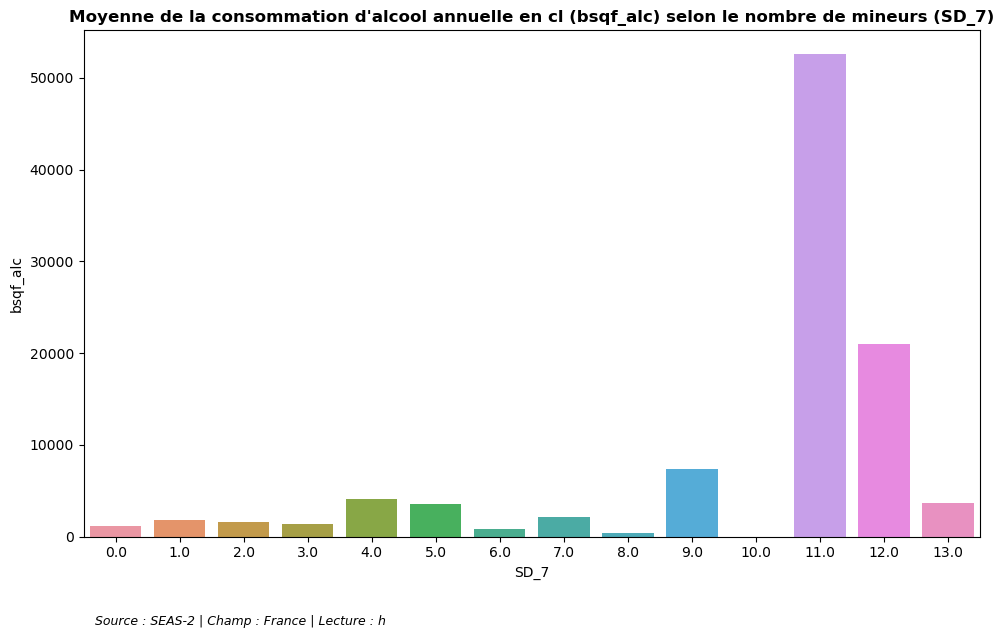

In [ ]:
# Barplot de la consommation d'alcool moyenne annuel par individus ayant le même nombre de mineur dans leur foyer
cld.tracer_barplot_vsbscqf(data, "Un répondant vivant dans un foyer sans mineur consomme en moyenne environ 10L (1000cl) d'alcool pur par an.", var_x="SD_7", var_y="bsqf_alc")

In [319]:
def tableau_dist_alc_par_mineur(data, lecture):
    # 1. On regroupe par nombre de mineurs et on calcule les stats sur bsqf_alc
    # mean = moyenne, 50% = médiane, std = écart-type, count = effectif
    tab_synthese = data.groupby('SD_7')['bsqf_alc'].agg(['mean', 'median', 'std', 'count']).round(2)
    
    # 2. Renommer les colonnes pour que ce soit plus parlant
    tab_synthese.columns = ['Moyenne (cl)', 'Médiane (cl)', 'Écart-type', 'Effectif']
    
    # 3. Affichage
    display(tab_synthese)
    print(f"Source : SEAS-2 | Champ : France | Lecture : {lecture}")

# Utilisation
tableau_dist_alc_par_mineur(data.dropna(subset=['SD_7', 'bsqf_alc']), 
                            "Distribution des statistiques de consommation d'alcool annuelle par nombre de mineurs au foyer.")

,Moyenne (cl),Médiane (cl),Écart-type,Effectif
SD_7,,,,
0.0,1173.12,197.95,8923.07,24130
1.0,1814.26,259.90,17816.35,10661
2.0,1561.58,250.00,11223.07,7035
3.0,1376.70,192.75,8838.89,1495
4.0,4060.80,103.15,43236.07,276
5.0,3565.40,148.50,12347.84,87
6.0,817.12,182.02,1357.67,21
7.0,2109.49,32.38,5262.08,7
8.0,401.22,401.22,335.71,2


Source : SEAS-2 | Champ : France | Lecture : Distribution des statistiques de consommation d'alcool annuelle par nombre de mineurs au foyer.


On remarque qu'il y a une assez forte variation de la consommation d'alcool selon le nombre de mineur dans le foyer. Les personnes qui ont un mineur dans leur foyer (y compris eux), parmi les répondants, consomment en moyenne plus d'une fois et demi plus que ceux qui n'ont pas de mineur dans leur foyer.  On remarquera qu'il n'est pas pertinent de prendre en compte les individus déclarant avoir plus de 6 enfants dans leurs foyers, qui sont trop peu nombreux et contiennent des outliers en termes de consommateurs d'alcool. 
Néanmoins on retiendra qu'il est intéressant de traiter les valeurs manquantes pour cette variable pour l'étudier, ce que l'on fera par la suite.
Encore une fois, une partie de l'effet constaté peut être dû à un biais de sélection sur les répondants/non répondants à SD_7, mais on suppose que cela ne crée pas tout l'effet.

*sd_20month - salaire mensuel*

Il est important de traiter le cas de la variable salaire sd_20month, car les facteurs économiques jouent, selon la littérature, un rôle important dans la consommation d'alcool (les plus favorisés auraient notamment tendance à consommer plus régulièrement de l'alcool mais en moins grande quantité). Le salaire étant la seule variable quantitative indiquant la situation économique des individus que nous ayont, nous devons traiter le problème de valeur manquante sur cette variable.

In [ ]:
missing_by_country = data.groupby('COUNTRY').apply(lambda x: x.isna().mean()) #on le remet car data a changé 
missing_by_country['sd_20month']
observation_count = data.groupby('COUNTRY').size()

# Ajouter le nombre d'observation par pays
missing_by_country['Observation_Count'] = observation_count

print(missing_by_country.loc[:, ["sd_20month", "Observation_Count"]])

                   sd_20month  Observation_Count
COUNTRY                                         
Austria              0.262257               3039
Belgium              0.251678               1490
BosniaHerzegovina    0.146015               1493
Bulgaria             0.208139               2998
Catalunya            0.295728               1498
Croatia              0.223632               1498
Cyprus               0.156691               1487
Czech Republic       0.168343               1491
Denmark              0.245198               1562
Estonia              0.524476               2145
Finland              0.166334               1503
France               0.128725               1678
Germany              0.153220               1475
Greece               0.230263               1520
Hungary              0.174987               1983
Iceland              0.094810               1445
Ireland              0.215962               1491
Italy                0.210280               1498
Latvia              

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_21820\1508566044.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_country = data.groupby('COUNTRY').apply(lambda x: x.isna().mean()) #on le remet car data a changé


In [ ]:
# 1.Voir combien de personnes ont été interrogées par pays
display(cld.tableau_effectifs_pays(data))

# 2. Voir le taux de non-réponse au revenu (sd_20month)
display(cld.tableau_na_pays(data, var="sd_20month"))

,Nombre d'observations
COUNTRY,
Austria,"3,039"
Bulgaria,"2,998"
Estonia,"2,145"
Hungary,"1,983"
France,"1,678"
Spain,"1,644"
Sweden,"1,616"
Denmark,"1,562"
Poland,"1,559"


,sd_20month
COUNTRY,
Austria,0.262257
Belgium,0.251678
BosniaHerzegovina,0.146015
Bulgaria,0.208139
Catalunya,0.295728
Croatia,0.223632
Cyprus,0.156691
Czech Republic,0.168343
Denmark,0.245198


Tous les pays ont un nombre conséquent d'observations (+de 1400). Nous obtiendrions donc des résultats statistiquements significatifs avec l'étude de chacun d'eux, ça n'est donc pas un critère pour sélectionner quel pays nous allons étudier.
Ils ont cependant des ratio de valeurs manquantes différents pour la variable salaire mensuelle sd_month, ce qui représentera un critère de sélection.
L'imputation des valeurs manquantes par sera ensuite faite seulement pour les pays sélectionnés.

**Choix des pays à étudier**

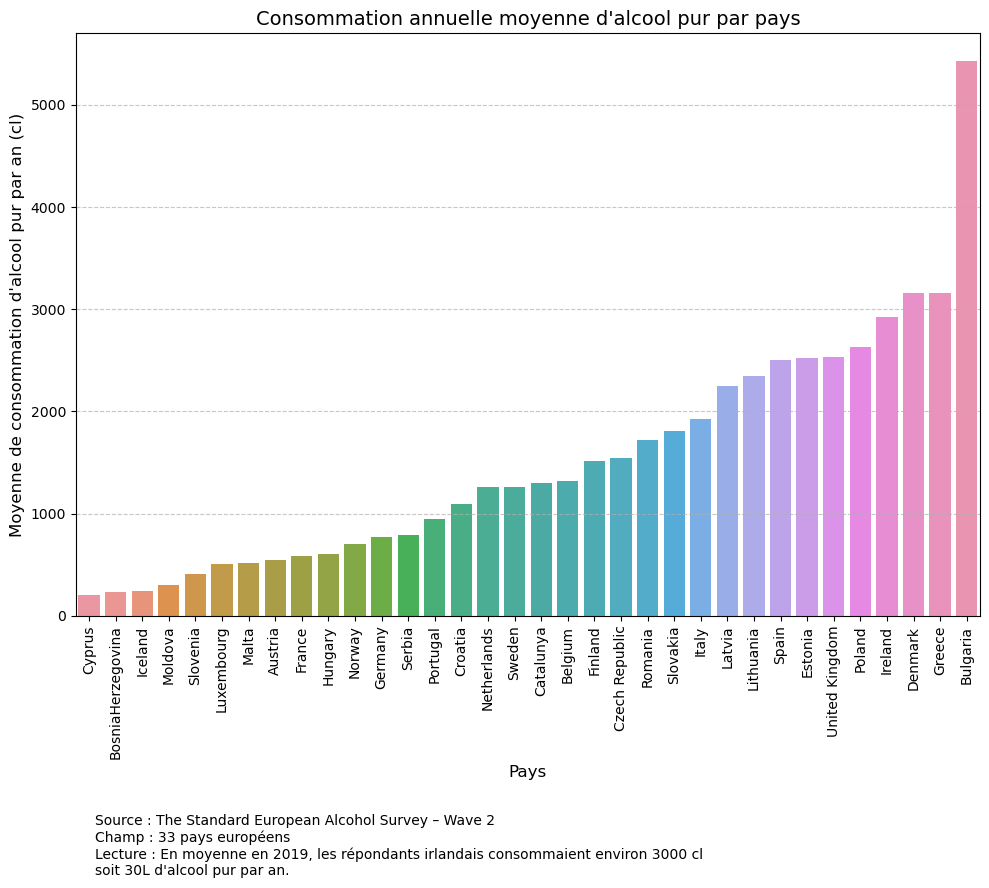

In [ ]:
#diagramme de la moyenne de consommation d'alcool par pays (en cl d'alcool pur par an)
# lecture spécifique pour ce graphique
note_lecture = (
    "Source : The Standard European Alcohol Survey – Wave 2\n"
    "Champ : 33 pays européens\n"
    "Lecture : En moyenne en 2019, les répondants irlandais consommaient environ 3000 cl\n"
    "soit 30L d'alcool pur par an."
)

# Appel de la fonction 
cld.barplot_bycntry(
    data, 
    colonne_y='bsqf_alc', 
    y_name="consommation d'alcool pur par an (cl)", 
    titre="Consommation annuelle moyenne d'alcool pur par pays",
    source = note_lecture
)

On notera que la consommation bulgare devra être étudiée en détail du fait de la très grande différence en consommation absolue par rapport aux autres pays. Nous avons choisi de prendre la version non capée de bsqf_alc, il s'agira donc de voir si certains outliers ne tirent pas la consommation moyenne vers le haut.

In [ ]:
# Calcul de la consommation moyenne par pays
stats_pays = data.groupby('COUNTRY')['bsqf_alc'].mean().reset_index()

# Chargement du fond de carte
world = gpd.read_file(r"C:\Users\Utilisateur\Documents\Ecole\S1\python\Fond_de_carte\110m_cultural\ne_110m_admin_0_countries.shp")

# Fusion données/fond de carte
europe = world[world['CONTINENT'] == 'Europe']
map_data = europe.merge(stats_pays, left_on='NAME', right_on='COUNTRY', how='left')


In [ ]:
# URL du GeoJSON - fond de carte europe
url = "https://raw.githubusercontent.com/datasets/geo-boundaries-world-110m/master/countries.geojson"

try:
    response = requests.get(url)
    #on lit le contenu JSON
    world = gpd.read_file(io.StringIO(response.text))
except Exception as e:
    print(f"Erreur : {e}")


world.columns = [c.upper() for c in world.columns]
europe = world[world['CONTINENT'] == 'Europe'].copy() # Filtrer l'Europe

# Fusion fond de carte/ données
# On associe les COUNTRY de notre dataset aux NAME de Geojson
map_data = europe.merge(pd.DataFrame(data), left_on='NAME', right_on='COUNTRY', how='left')

europe = europe.set_geometry('GEOMETRY')

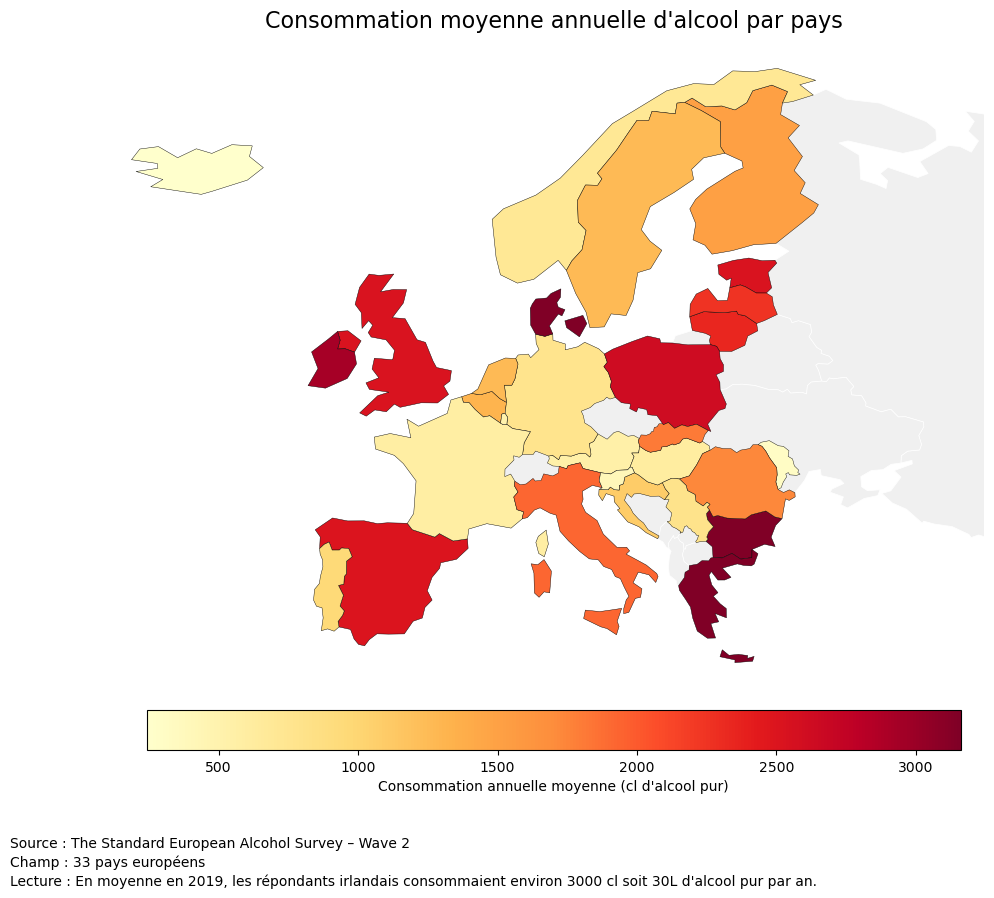

In [ ]:
import clean_data as cld
import importlib
importlib.reload(cld)

# --- CARTE 1 : ALCOOL ---
texte_alc = (
    "Source : The Standard European Alcohol Survey – Wave 2\n"
    "Champ : 33 pays européens\n"
    "Lecture : En moyenne en 2019, les répondants irlandais consommaient environ 3000 cl soit 30L d'alcool pur par an."
)
cld.trace_carte_europe(data, europe, 'bsqf_alc', 
                        "Consommation moyenne annuelle d'alcool par pays", 
                        "Consommation annuelle moyenne (cl d'alcool pur)", texte_alc)



In [ ]:
data.groupby('COUNTRY')['bsqf_alc'].mean().sort_values(ascending=True)

COUNTRY
Cyprus                205.198107
BosniaHerzegovina     236.640506
Iceland               242.589647
Moldova               300.142423
Slovenia              406.714585
Luxembourg            510.276905
Malta                 514.330204
Austria               548.083531
France                585.695441
Hungary               609.769031
Norway                703.774055
Germany               773.758070
Serbia                794.984060
Portugal              950.801565
Croatia              1094.511644
Netherlands          1264.307564
Sweden               1265.684537
Catalunya            1300.424266
Belgium              1319.344460
Finland              1514.336666
Czech Republic       1549.297912
Romania              1724.810394
Slovakia             1813.477194
Italy                1924.703092
Latvia               2250.058178
Lithuania            2349.951613
Spain                2500.592609
Estonia              2526.571155
United Kingdom       2530.450822
Poland               2627.596199
Ir

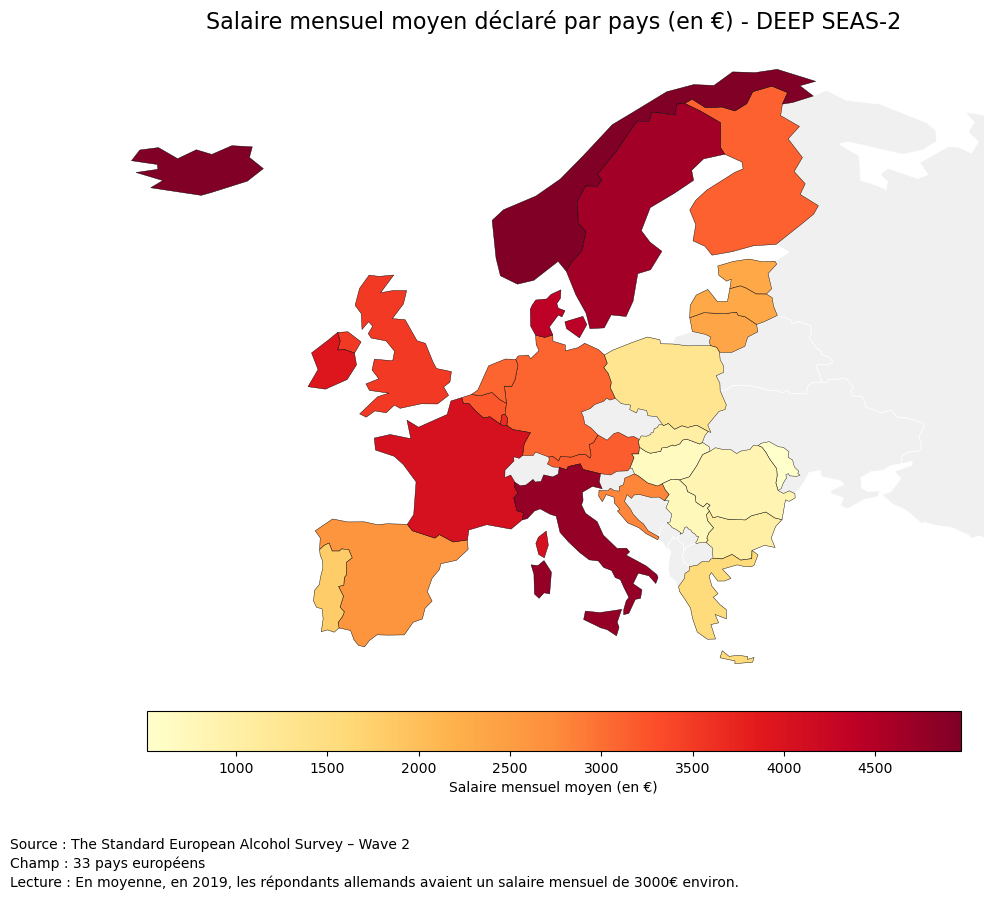

In [ ]:
#CARTE 2 :SALAIRE MENSUEL MOYEN
texte_salaire = (
    "Source : The Standard European Alcohol Survey – Wave 2\n"
    "Champ : 33 pays européens\n"
    "Lecture : En moyenne, en 2019, les répondants allemands avaient un salaire mensuel de 3000€ environ."
)

cld.trace_carte_europe(
    data=data, 
    europe=europe, 
    colonne='sd_20month_EUR_2020', 
    titre="Salaire mensuel moyen déclaré par pays (en €) - DEEP SEAS-2", 
    label_legende="Salaire mensuel moyen (en €)", 
    texte_info=texte_salaire
)

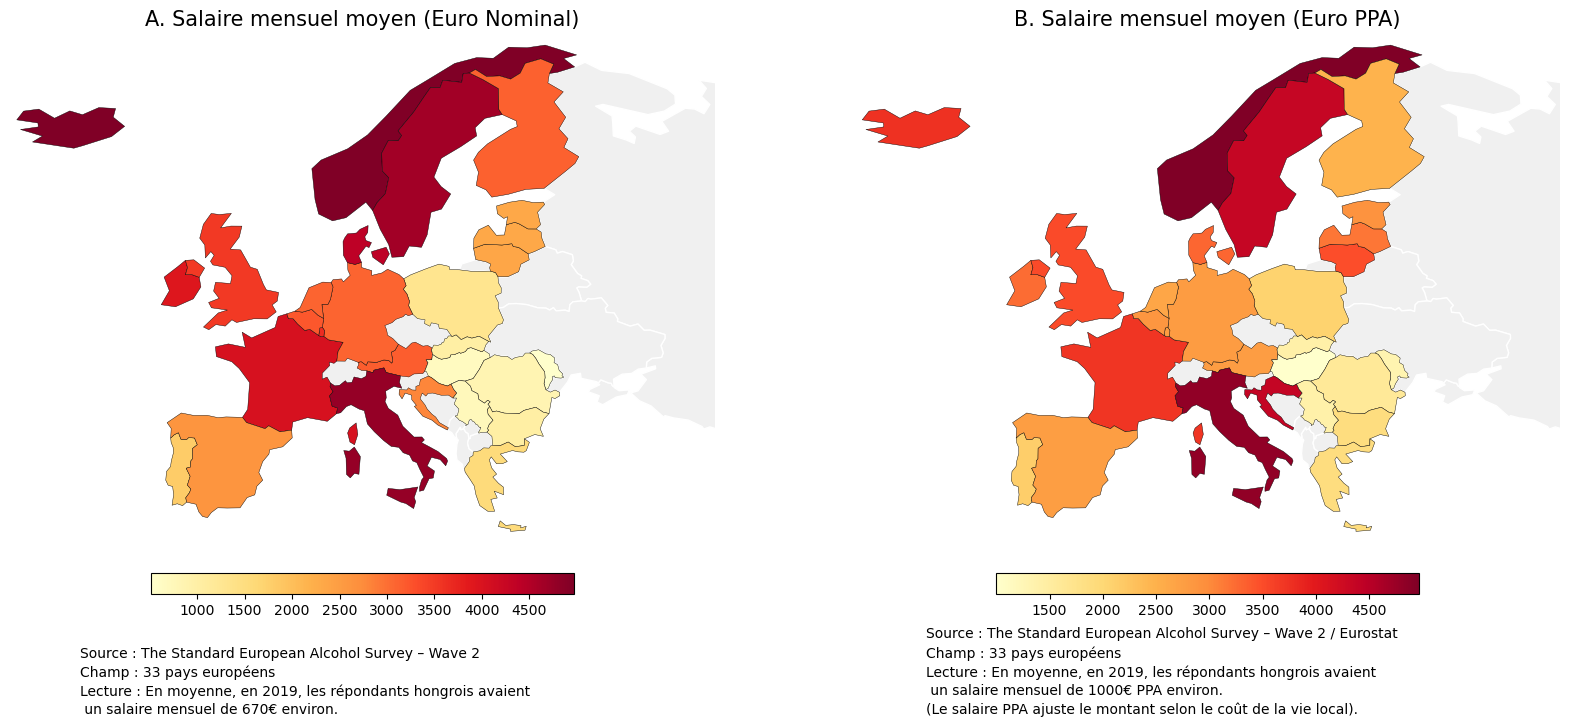

In [ ]:
import clean_data as cld
import importlib
importlib.reload(cld)
# CARTE COMPARATIVE PPA vs nomial
txt_a = (
    "Source : The Standard European Alcohol Survey – Wave 2\n"
    "Champ : 33 pays européens\n"
    "Lecture : En moyenne, en 2019, les répondants hongrois avaient\n un salaire mensuel de 670€ environ."
)
txt_b = (
    "Source : The Standard European Alcohol Survey – Wave 2 / Eurostat\n"
    "Champ : 33 pays européens\n"
    "Lecture : En moyenne, en 2019, les répondants hongrois avaient\n un salaire mensuel de 1000€ PPA environ.\n(Le salaire PPA ajuste le montant selon le coût de la vie local)."
)
cld.compare_cartes_ppa(data, europe, 'sd_20month_EUR_2020', 'sd_20month_EUR_2020_PPA', txt_a, txt_b)

Il y a peu de différence entre la distribution des salaires par pays en nominal et en PPA (notamment dû au large gradient de couleur qui rend moins importantes des variations de quelques centaines d'euros). La hiérarchie semble néanmoins rester la même, on utilisera donc l'une ou l'autre des unités indifféremment pour comparer les pays.

In [ ]:
data.groupby('COUNTRY')['sd_20month_EUR_2020_PPA'].mean().sort_values(ascending=True)

COUNTRY
Hungary              1000.525453
Moldova              1320.302041
Serbia               1391.850270
Slovakia             1411.820068
BosniaHerzegovina    1442.680851
Romania              1604.241620
Greece               1886.080971
Bulgaria             1888.292213
Poland               2082.692471
Portugal             2138.848183
Cyprus               2336.843905
Czech Republic       2352.764534
Finland              2485.928874
Netherlands          2643.956129
Spain                2761.678175
Austria              2772.987197
Luxembourg           2786.352713
Germany              2790.839321
Malta                2794.683000
Belgium              2864.119925
Estonia              2899.643310
Catalunya            2965.025889
Latvia               3167.941769
Ireland              3236.245399
Denmark              3285.524695
Lithuania            3482.017814
United Kingdom       3512.054745
France               3725.517811
Iceland              3748.062540
Sweden               4348.160309
Cr

Refaire une autre carte ou prendre sur internet pour critiquer distribution ici avec d'autres données.

In [ ]:
data_na = data.copy()
data_na['sd_20month_EUR_2020'] = data_na['sd_20month_EUR_2020'].isna()

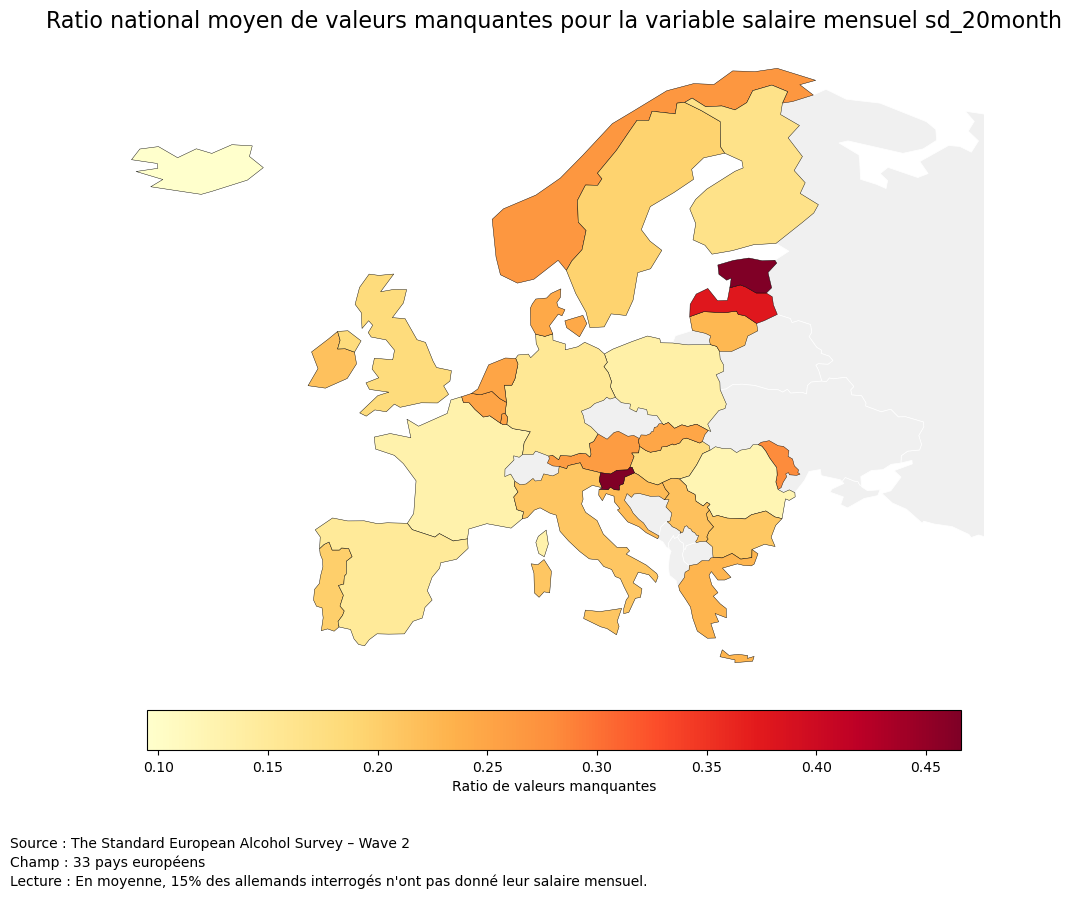

In [ ]:
# CARTE 4 : VALEURS MANQUANTES (NA) 
texte_na = (
    "Source : The Standard European Alcohol Survey – Wave 2\n"
    "Champ : 33 pays européens\n"
    "Lecture : En moyenne, 15% des allemands interrogés n'ont pas donné leur salaire mensuel."
)

cld.trace_carte_europe(
    data=data_na, # On utilise ici le dataframe des moyennes de NA
    europe=europe, 
    colonne='sd_20month_EUR_2020', 
    titre="Ratio national moyen de valeurs manquantes pour la variable salaire mensuel sd_20month", 
    label_legende="Ratio de valeurs manquantes", 
    texte_info=texte_na
)

In [ ]:
data_na.groupby('COUNTRY')['sd_20month_EUR_2020'].mean().sort_values(ascending=True)

COUNTRY
Iceland              0.094810
Romania              0.120989
France               0.128725
Poland               0.134060
BosniaHerzegovina    0.146015
Spain                0.149635
Germany              0.153220
Cyprus               0.156691
Finland              0.166334
Czech Republic       0.168343
Hungary              0.174987
United Kingdom       0.181575
Malta                0.188187
Sweden               0.194926
Portugal             0.199331
Bulgaria             0.208139
Italy                0.210280
Serbia               0.215436
Ireland              0.215962
Croatia              0.223632
Lithuania            0.226880
Greece               0.230263
Denmark              0.245198
Slovakia             0.248493
Netherlands          0.250674
Belgium              0.251678
Luxembourg           0.252168
Austria              0.262257
Norway               0.267748
Moldova              0.280374
Catalunya            0.295728
Latvia               0.377837
Estonia              0.524476
Sl

In [ ]:
data_na_rsod= data.copy()
data_na_rsod['RSOD_2bcorrected']= data['RSOD_2bcorrected'].isna()
data_na_rsod.groupby('COUNTRY')['RSOD_2bcorrected'].mean().sort_values(ascending=True)

COUNTRY
Finland              0.092482
Bulgaria             0.093729
Poland               0.098140
Ireland              0.117371
Estonia              0.118881
Latvia               0.130841
Czech Republic       0.132126
Croatia              0.147530
Norway               0.153482
Greece               0.155921
Sweden               0.162129
Slovakia             0.174816
Serbia               0.181879
Lithuania            0.182967
Belgium              0.185235
United Kingdom       0.202937
Austria              0.229352
Germany              0.234576
Romania              0.241979
Hungary              0.250126
Netherlands          0.254717
Denmark              0.254802
Malta                0.256181
Italy                0.265688
Slovenia             0.274814
Spain                0.283455
Portugal             0.288963
Catalunya            0.307076
Iceland              0.332180
France               0.386770
Moldova              0.417223
Luxembourg           0.417612
BosniaHerzegovina    0.429337
Cy

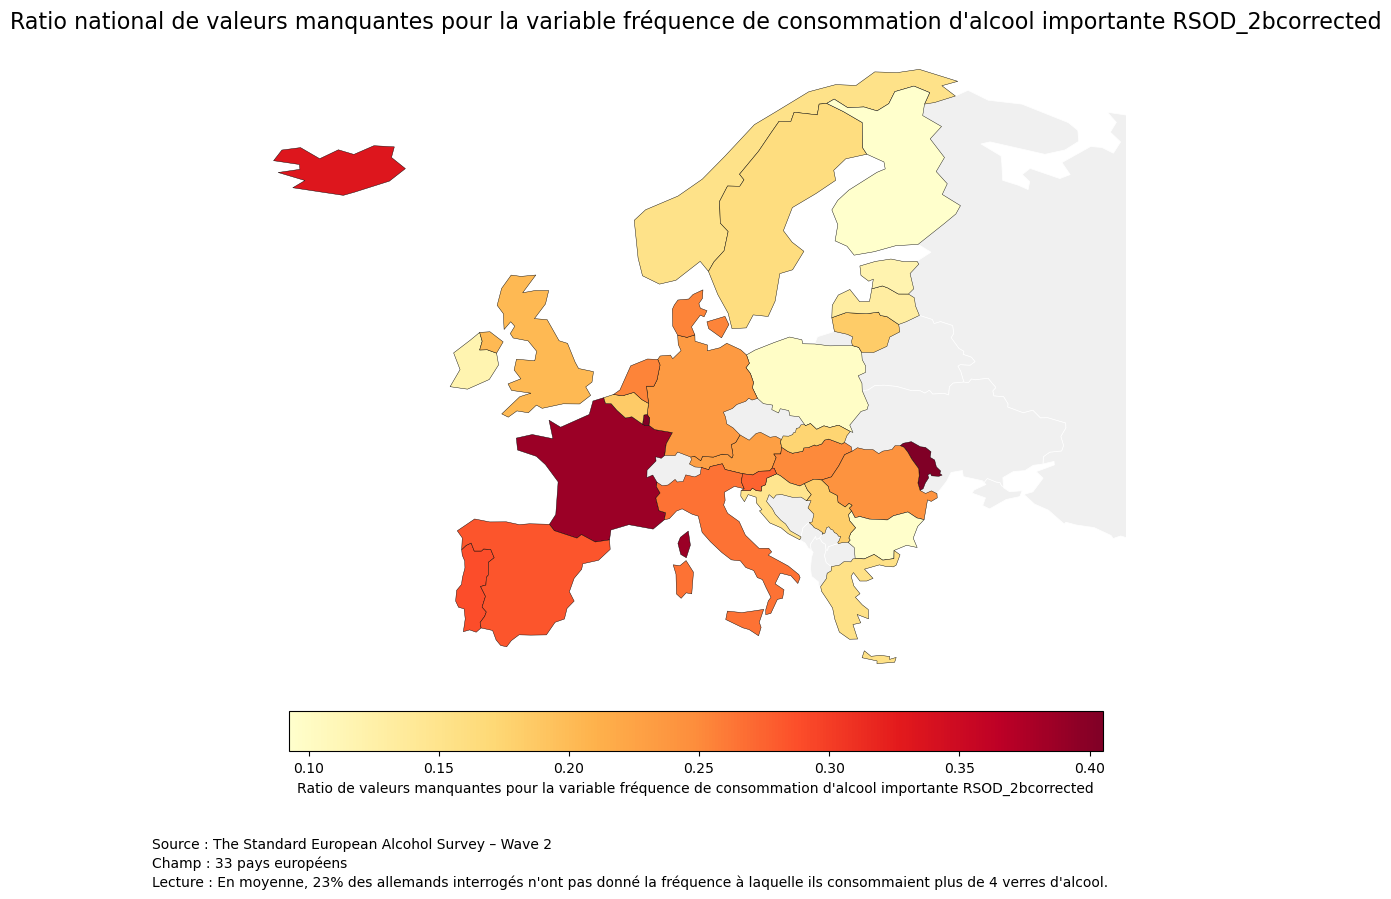

In [ ]:
#CARTE 5 : VALEURS MANQUANTES de la consommation ponctuelle importante d'alcool (RSOD_2bcorrected)
texte_rsod_na = (
    "Source : The Standard European Alcohol Survey – Wave 2\n"
    "Champ : 33 pays européens\n"
    "Lecture : En moyenne, 23% des allemands interrogés n'ont pas donné la fréquence à laquelle "
    "ils consommaient plus de 4 verres d'alcool."
)

cld.trace_carte_europe(
    data=data_na_rsod, 
    europe=europe, 
    colonne='RSOD_2bcorrected', 
    titre="Ratio national de valeurs manquantes pour la variable fréquence de consommation d'alcool importante RSOD_2bcorrected", 
    label_legende="Ratio de valeurs manquantes pour la variable fréquence de consommation d'alcool importante RSOD_2bcorrected", 
    texte_info=texte_rsod_na
)

On veut étudier des pays culturellement et économiquement suffisamment différents, pour voir s'il s'en dégagent aussi des profils de consommateurs d'alcool différents.
On essaye donc de choisir au moins un pays où, dans nos données, 
1. la consommation d'alcool moyenne:
    -  est faible (France, Allemagne, Autriche, Islande, Chypre,etc.);
    -  est élevée voire très élevée (Pologne, UK, Irlande, Grèce, Bulgarie, Estonie, Espagne,etc.);
2. les salaires sont en moyenne:
    - élevés (Islande, Suède, Norvège,Irlande)
    - intermédiaires (France, Allemagne, Finlande, Pays- Bas, etc.)
    - faible (Hongrie, Portugal, Pologne, Serbie, etc.)
Parmi ces pays, on essaye de choisir ceux qui n'ont pas trop de valeurs manquantes surtout pour la variables sd_20month pour les raisons évoquées ci-avant.
On essaye également de choisir des pays à différents endroits du continents européens pour voir l'influence des caractéristiques culturelles (ex: type de boissons consommées selon les espaces géographiques).

Ces considérations nous conduisent à choisir les quatres pays suivants: la Bulgarie, la France, l'Islande et la Pologne. 

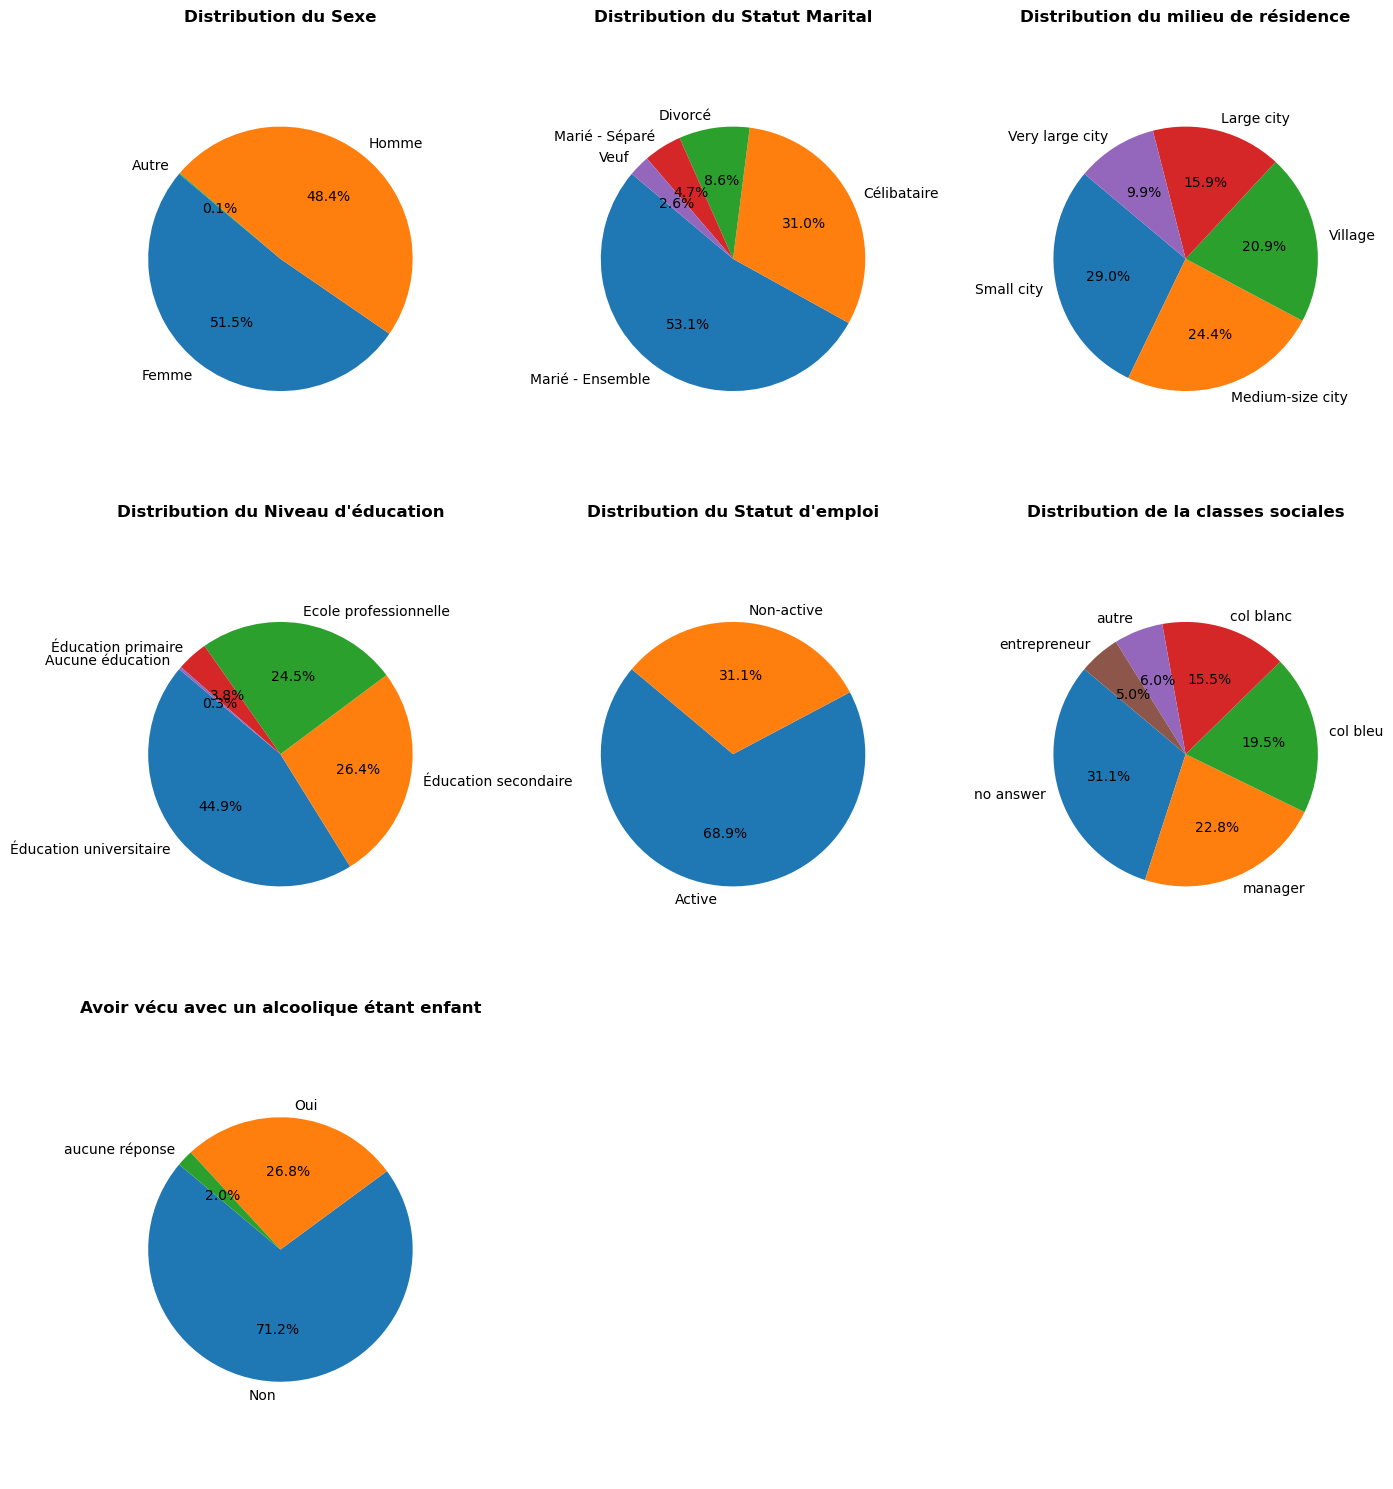

In [ ]:
# Diagramme circulaire de certaines variables qualitatives

qualitative = ["SD_1", "SD_4", "SD_8", "SD_9", "SD_10", "social_class", "CH_1"]
n_cols = 3
n_rows = (len(qualitative) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5*n_rows))
axes = axes.flatten()

# Sexe (SD_1)
counts = data["SD_1"].value_counts()
etiquettes_SD1 = {1: 'Homme', 2: 'Femme', 3: 'Autre'}
labels_SD1 = [etiquettes_SD1.get(x, x) for x in counts.index]
axes[0].pie(counts, labels=labels_SD1, autopct='%1.1f%%', startangle=140)
axes[0].set_title('Distribution du Sexe', fontsize=12, fontweight='bold')
axes[0].axis('equal')

# Statut marital (SD_4)
counts = data["SD_4"].value_counts()
etiquettes_SD4 = {
    1: 'Marié - Ensemble',
    2: 'Marié - Séparé',
    3: 'Célibataire',
    4: 'Divorcé',
    5: 'Veuf'
}
labels_SD4 = [etiquettes_SD4.get(x, x) for x in counts.index]
axes[1].pie(counts, labels=labels_SD4, autopct='%1.1f%%', startangle=140)
axes[1].set_title('Distribution du Statut Marital', fontsize=12, fontweight='bold')
axes[1].axis('equal')

# Type de résidence (SD_8)
counts = data["SD_8"].value_counts()
etiquettes_SD8 = {
    1: 'Village',
    2: 'Small city',
    3: 'Medium-size city',
    4: 'Large city',
    5: 'Very large city'
}
labels_SD8 = [etiquettes_SD8.get(x, x) for x in counts.index]
axes[2].pie(counts, labels=labels_SD8, autopct='%1.1f%%', startangle=140)
axes[2].set_title('Distribution du milieu de résidence', fontsize=12, fontweight='bold')
axes[2].axis('equal')

# Niveux d'éducation (SD_9)
counts = data["SD_9"].value_counts()
etiquettes_SD9 = {
    1: 'Éducation primaire',
    2: 'Éducation secondaire',
    3: 'Ecole professionnelle',
    4: 'Éducation universitaire',
    5: 'Aucune éducation'
}

labels_SD9 = [etiquettes_SD9.get(x, x) for x in counts.index]
axes[3].pie(counts, labels=labels_SD9, autopct='%1.1f%%', startangle=140)
axes[3].set_title('Distribution du Niveau d\'éducation', fontsize=12, fontweight='bold')
axes[3].axis('equal')

# statut d'emploi (SD_10)
counts = data["SD_10"].value_counts()
etiquettes_SD10 = {
    1: 'Active',
    2: 'Non-active'
}
labels_SD10 = [etiquettes_SD10.get(x, x) for x in counts.index]
axes[4].pie(counts, labels=labels_SD10, autopct='%1.1f%%', startangle=140)
axes[4].set_title('Distribution du Statut d\'emploi', fontsize=12, fontweight='bold')
axes[4].axis('equal')

# social_class
counts = data["social_class"].value_counts()
etiquettes_social_class = {    
    1: 'col bleu',
    2: 'col blanc',
    3: 'manager',
    4: 'entrepreneur',
    5: 'autre',
    9: 'no answer'
}
labels_social_class = [etiquettes_social_class.get(x, x) for x in counts.index]
axes[5].pie(counts, labels=labels_social_class, autopct='%1.1f%%', startangle=140)
axes[5].set_title('Distribution de la classes sociales', fontsize=12, fontweight='bold')
axes[5].axis('equal')

# avoir vecu avec un alcoolique (CH_1)
counts = data["CH_1"].value_counts()   
etiquettes_CH1 = {
    1: 'Oui',
    2: 'Non',
    3: 'aucune réponse'
}
labels_CH1 = [etiquettes_CH1.get(x, x) for x in counts.index]         
axes[6].pie(counts, labels=labels_CH1, autopct='%1.1f%%', startangle=140)
axes[6].set_title('Avoir vécu avec un alcoolique étant enfant', fontsize=12, fontweight='bold')
axes[6].axis('equal')



# Masquer les subplots inutilisés
for idx in range(len(qualitative), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

c:\Users\Utilisateur\Documents\Téléchargements\Anaconda\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


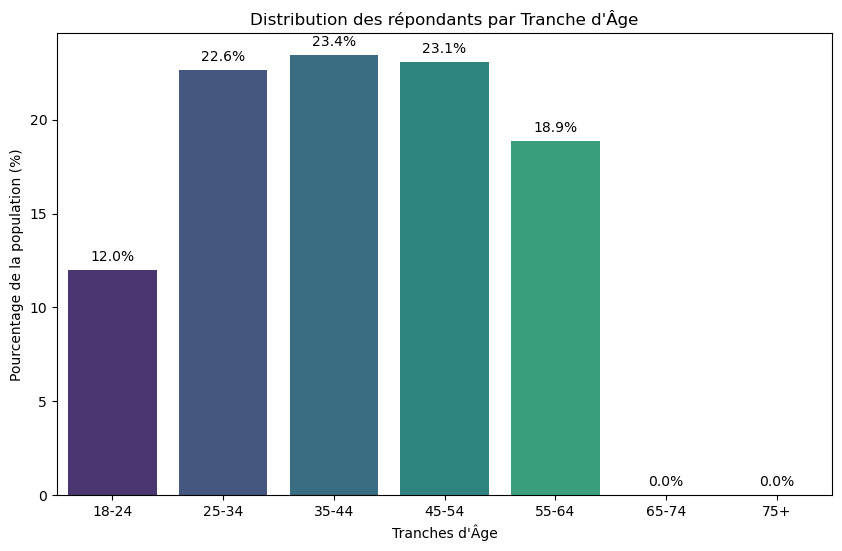


Distribution par Tranche d'Âge (en %):
Age_Tranche
18-24    12.0%
25-34    22.6%
35-44    23.4%
45-54    23.1%
55-64    18.9%
65-74     0.0%
75+       0.0%
Name: proportion, dtype: object


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Création de la variable de tranches d'âge ---
bins = [18, 25, 35, 45, 55, 65, 75, 100]
labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75+']

data['Age_Tranche'] = pd.cut(
    data['SD_2'],
    bins=bins,
    labels=labels,
    right=False,
    include_lowest=True
)

# --- 2. Préparation des données pour le Barplot (Pourcentages) ---
age_distribution = data['Age_Tranche'].value_counts(normalize=True).mul(100).sort_index()

# --- 3. Création du Barplot ---
plt.figure(figsize=(10, 6))

sns.barplot(
    x=age_distribution.index,
    y=age_distribution.values,
    palette='viridis'
)

plt.title('Distribution des répondants par Tranche d\'Âge')
plt.xlabel('Tranches d\'Âge')
plt.ylabel('Pourcentage de la population (%)')

# Ajout des pourcentages au-dessus des barres
for index, value in enumerate(age_distribution.values):
    plt.text(index, value + 0.5, f'{value:.1f}%', ha='center')

plt.show()

# 

print("\nDistribution par Tranche d'Âge (en %):")
print(age_distribution.round(1).astype(str) + '%')

In [ ]:
#statistiques descriptives de toutes les variables quantitatives
tab = data.select_dtypes(include='float').describe().T[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
labels = {
    'SD_2': 'Age',
    'SD_7': 'Nombre d\'enfant dans le foyer',
    'sd_20month': 'Salaire mensuel',
    'bsqf_alc': 'Consommation alcool annuel',
    'rf_1b': 'Frequence consommation alcool',
    'RSOD_2b': 'Fréquence de grande consommation',
    'RSOD_7b': 'Variable RSOD_7b'
    # Ajoutez les autres variables selon vos besoins
}

# Ajouter la colonne label en première position
tab.insert(0, 'label', tab.index.map(labels))
styled_tab = tab.style \
    .format({col: '{:.2f}' for col in tab.columns if col != 'label'}) \
    .set_properties(**{'text-align': 'center'}) \
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#4472C4'), ('color', 'white'), ('font-weight', 'bold')]},
        {'selector': 'td', 'props': [('padding', '10px'), ('color', 'black')]},
        {'selector': 'tbody tr:nth-child(even)', 'props': [('background-color', '#E7E6E6')]},
        {'selector': 'tbody tr:nth-child(odd)', 'props': [('background-color', '#F2F2F2')]}
    ])

styled_tab

,label,count,mean,std,min,25%,50%,75%,max
SD_2,Age,56014.00,41.06,12.82,18.00,30.00,41.00,52.00,64.00
sd_20month,Salaire mensuel,42456.00,41727.56,143282.45,125.00,1500.04,3000.50,11250.00,1380000.00
bsqf_alc,Consommation alcool annuel,55483.00,1606.70,16055.35,0.00,33.67,216.75,797.47,1544380.00


In [ ]:
import pandas as pd
import numpy as np
#Pourcentage d'outliers par pays en par rapport aux quantiles PAR PAYS

# --- 1. Définition de la fonction de calcul du pourcentage d'outliers ---
def calculate_outlier_percentage(series):
    """
    Calcule le pourcentage de valeurs aberrantes (outliers) dans une série
    en utilisant la méthode de l'Écart InterQuartile (IQR).
    """
    # Exclure les valeurs manquantes avant le calcul
    series = series.dropna()

    # Si le pays n'a aucune donnée, retourner 0%
    if series.empty:
        return 0.0

    # 1. Calculer les quartiles et l'IQR
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    # 2. Définir les limites
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # 3. Compter les valeurs aberrantes
    outliers_count = series[(series < lower_bound) | (series > upper_bound)].count()

    # 4. Calculer le pourcentage
    total_count = series.count()
    outlier_percentage = (outliers_count / total_count) * 100

    return outlier_percentage

# --- 2. Application de la fonction par pays ---
# On utilise groupby() sur 'COUNTRY' et apply() la fonction sur 'bsqf_alc'.

outlier_percentage_by_country = (
    data
    .groupby('COUNTRY')['bsqf_alc']
    .apply(calculate_outlier_percentage)
    .sort_values(ascending=False)
)

# --- 3. Affichage des résultats ---

print("="*70)
print("Pourcentage de valeurs aberrantes (Outliers) de 'bsqf_alc' par pays (Méthode IQR)")
print("="*70)

# Filtrer et formater pour l'affichage (seulement les pays avec des outliers)
outlier_df = outlier_percentage_by_country[outlier_percentage_by_country > 0].reset_index(name='Pourcentage_Outliers')

# Arrondir le pourcentage à deux décimales et ajouter le signe %
outlier_df['Pourcentage_Outliers'] = outlier_df['Pourcentage_Outliers'].round(2).astype(str) + '%'

print(outlier_df)
print("\n")

# Affichage des statistiques sommaires
print(f"\nPourcentage d'outliers moyen dans tous les pays: {outlier_percentage_by_country.mean():.2f}%")
print(f"Pays avec le pourcentage maximum: {outlier_percentage_by_country.idxmax()} ({outlier_percentage_by_country.max():.2f}%)")

Pourcentage de valeurs aberrantes (Outliers) de 'bsqf_alc' par pays (Méthode IQR)
              COUNTRY Pourcentage_Outliers
0             Denmark               14.15%
1               Malta                13.6%
2   BosniaHerzegovina                13.4%
3             Estonia               12.77%
4           Catalunya               12.62%
5              Norway               12.31%
6             Iceland               12.25%
7              Latvia               12.15%
8             Belgium               11.81%
9               Spain               11.68%
10           Bulgaria               11.54%
11          Lithuania               11.44%
12            Moldova               11.42%
13             Sweden               11.32%
14           Slovenia               11.28%
15            Austria               11.25%
16             Cyprus               11.23%
17           Slovakia               11.19%
18            Ireland               10.93%
19             Greece               10.86%
20            G

In [ ]:


# --- 1. Calcul des bornes d'outliers globales sur l'ensemble de la base de données ---
series_global = data['bsqf_alc'].dropna()

Q1_global = series_global.quantile(0.25)
Q3_global = series_global.quantile(0.75)
IQR_global = Q3_global - Q1_global

lower_bound_global = Q1_global - 1.5 * IQR_global
upper_bound_global = Q3_global + 1.5 * IQR_global


# --- 2. Définition de la fonction de calcul du pourcentage d'outliers globaux par pays ---
def calculate_global_outlier_percentage(group, lower_bound, upper_bound):
    """
    Calcule le pourcentage d'outliers dans un groupe (pays) en utilisant
    les bornes globales fournies.
    """
    series = group.dropna()

    if series.empty:
        return 0.0

    # Compter les valeurs aberrantes par rapport aux bornes globales
    outliers_count = series[(series < lower_bound) | (series > upper_bound)].count()

    # Calculer le pourcentage par rapport au total des observations non manquantes du pays
    total_count = series.count()
    outlier_percentage = (outliers_count / total_count) * 100

    return outlier_percentage

# --- 3. Application de la fonction par pays ---
outlier_percentage_global = (
    data
    .groupby('COUNTRY')['bsqf_alc']
    .apply(calculate_global_outlier_percentage, lower_bound=lower_bound_global, upper_bound=upper_bound_global)
    .sort_values(ascending=False)
)

# --- 4. Affichage des résultats ---
print(f"Bornes d'outliers globales (sur l'ensemble des données): Q1={Q1_global:.2f}, Q3={Q3_global:.2f}")
print(f"Limite Inférieure = {lower_bound_global:.2f}, Limite Supérieure = {upper_bound_global:.2f}\n")

print("="*70)
print("Pourcentage de valeurs aberrantes (Outliers) de 'bsqf_alc' par pays (Bornes Globales)")
print("="*70)

outlier_df = outlier_percentage_global.reset_index(name='Pourcentage_Outliers_Global')
outlier_df['Pourcentage_Outliers_Global'] = outlier_df['Pourcentage_Outliers_Global'].round(2).astype(str) + '%'
print(outlier_df)

Bornes d'outliers globales (sur l'ensemble des données): Q1=33.67, Q3=797.47
Limite Inférieure = -1112.04, Limite Supérieure = 1943.18

Pourcentage de valeurs aberrantes (Outliers) de 'bsqf_alc' par pays (Bornes Globales)
              COUNTRY Pourcentage_Outliers_Global
0            Bulgaria                      27.25%
1      United Kingdom                      19.96%
2               Spain                      19.65%
3              Poland                      19.31%
4             Ireland                      17.84%
5             Romania                      16.58%
6             Estonia                      15.38%
7             Belgium                      15.03%
8      Czech Republic                      15.02%
9             Denmark                      14.92%
10              Italy                      14.29%
11           Slovakia                      13.13%
12             Greece                       12.7%
13          Catalunya                      12.55%
14            Finland       

On remarque qu'il n'y a pas d'énormes différences dans les taux de valeurs aberrante de la consommation d'alcool quand ces outliers sont calculés chacuns par rapport au quartile de leur pays. Par contre, il y a de grosses différences de pourcentages de valeurs aberrantes quand on les calculs tous par rapport aux quantiles du dataset global (et les plus grands (resp. + petits) pourcentages d'outliers de ce point de vue sont en moyenne dans les pays qui déclarent consommer en moyenne plus d'alcool (resp. moins d'alcool) ). Ceci est rassurant, cela veut dire que soit il y a des pays extrêmes en termes de consommation d'alcool qui participent donc à créer beaucoup plus ces outliers que les autres, soit dans ces pays il y a des individus qui sur/sous évaluent leur consommation d'alcool plus que dans d'autres pays, ce qui dans les deux cas pourra participer à notre analyse, une fois faites la sélection des pays. Il ne semble donc pas y avoir de problème généralisé de valeurs abberantes non interprétable pour la variable de consommation d'alcool bsqf.

**PARTIE II**

In [171]:
# Sélection des variables quantitatives 
quanti = data[[
    "SD_2",          # Âge 
    "SD_7",          # Nombre de mineurs au foyer 
    "sd_20month",    # Revenu mensuel 
    "bsqf_alc",      # Consommation annuelle totale d'alcool 
    "cbsqf_beer",    # Consommation annuelle de bière(plafonnée) 
    "cbsqf_spir",    # Consommation annuelle de spiritueux (plafonnée) 
    "cbsqf_wine"     # Consommation annuelle de vin (plafonnée) 
]]

# Sélection des variables qualitatives 
quali = data[[
    "COUNTRY",       # Pays de résidence
    "SD_1",          # Genre 
    "SD_4",          # Statut matrimonial 
    "SD_6",          # vie seul ou non
    "SD_8",          # Type de lieu de résidence 
    "SD_9",          # Niveau d'éducation 
    "SD_10",         # Statut d'activité professionnelle 
    "social_class",  # Classe sociale auto-déclarée 
    "f_1b",          # Fréquence générique de consommation 
    "RSOD_2b",       # Fréquence de consommation de 4/6+ verres 
    "RSOD_7b",       # Fréquence de consommation de 8/12+ verres 
    "CH_1",          # Contact avec un gros buveur durant l'enfance 
    "WB_1",          # État de santé général 
    "WB_2",          # Bien-être psychologique 
    "WB_3"           # Satisfaction des relations sociales
]]

In [172]:
#TEMPORAIRE POUR ESSAIS - IMPUTATION PAR MOYENNE ET MODE LE PLUS FREQUENT

# Imputation par la moyenne pour les variables quantitatives
# Concerne : SD_2, SD_7, sd_20month, bsqf_alc, cbsqf_beer, cbsqf_spir, cbsqf_wine
data[quanti.columns] = data[quanti.columns].fillna(data[quanti.columns].mean())

# Imputation par le mode (le plus fréquent) pour les variables qualitatives
# Concerne : COUNTRY, SD_1, SD_4, SD_6, SD_8, SD_9, SD_10, Demo_Empl, social_class, etc.
data[quali.columns] = data[quali.columns].fillna(data[quali.columns].mode().iloc[0])

ACP/ACM pour la France:

*ACP France*

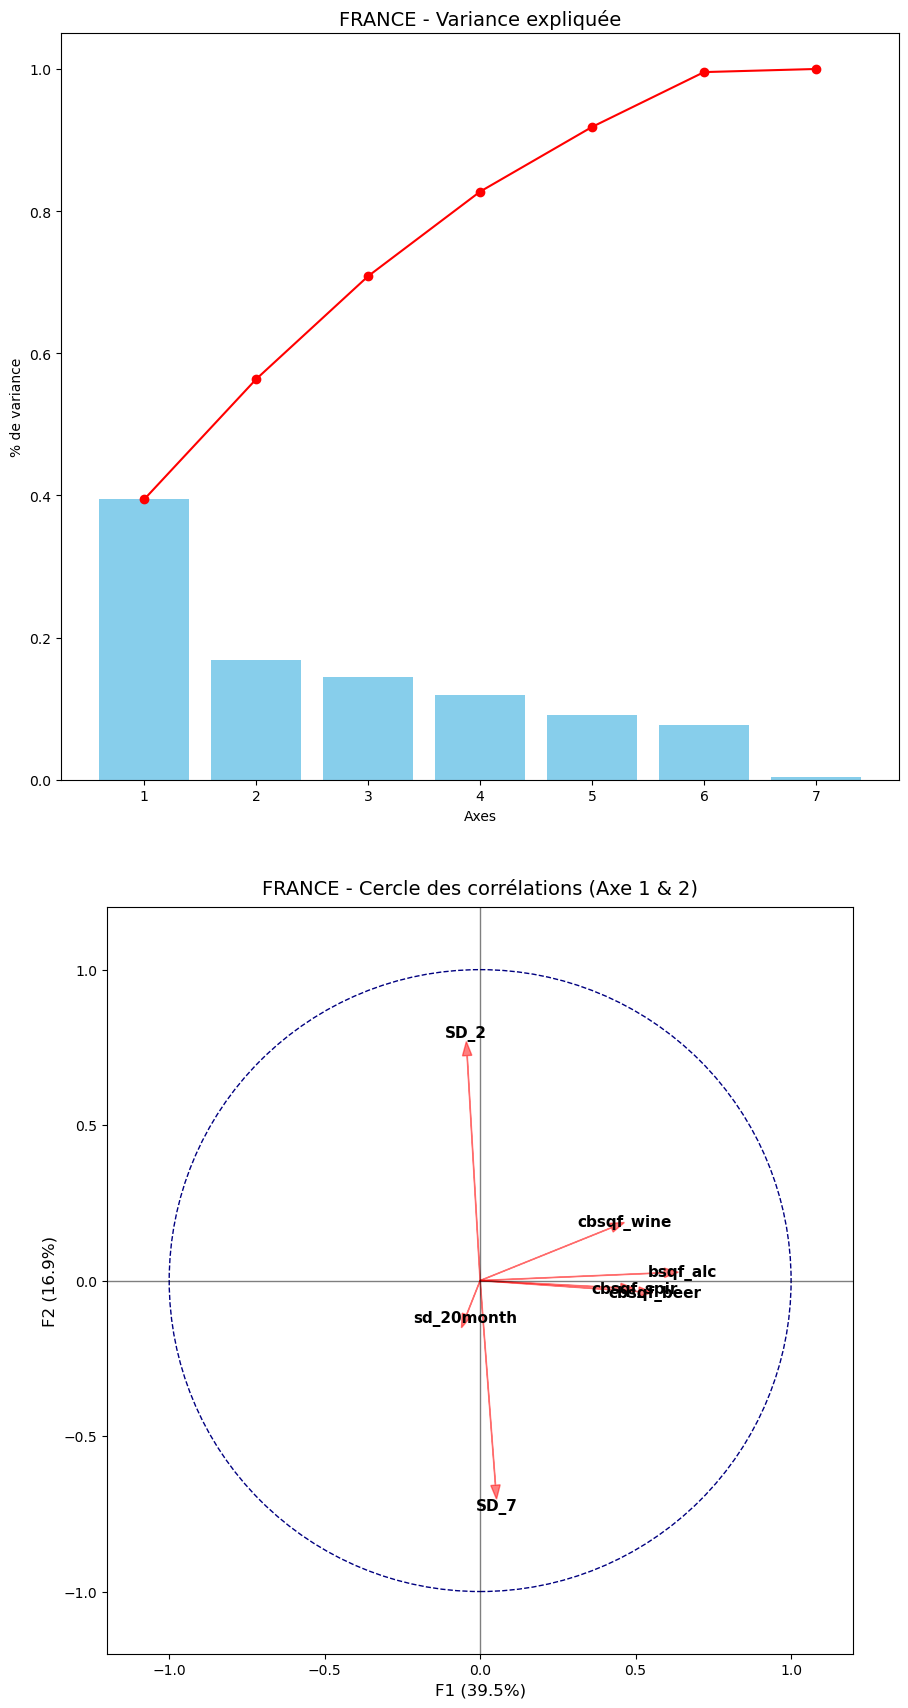

In [173]:
import Data_analysis as dtn
import importlib
importlib.reload(dtn)

# On calcule l'ACP sur les quanti.colums/ variables quantitatives
pca_fr, feat_fr, cols_fr = dtn.calculer_acp_pays(data, "France", quanti.columns)

# Et on trace
if pca_fr is not None:
    dtn.trace_cercle_et_variance(pca_fr, cols_fr, "FRANCE")


Les matrices de variance des ACP de chaque pays sont dans la partie II de l'annexe.

In [174]:
#Calcul des individus les plus représentatifs avec leur Cos^2

# on ne garde que les colonnes quantitatives de la France
data_pays = data[data['COUNTRY'] == "France"][quanti.columns].copy()

#Normalisation indispensable pour le calcul du co^2 
scaler = StandardScaler()
X_scaled_pays = scaler.fit_transform(data_pays)


# Calcul du cos^2
df_cos2 = dtn.calculer_cos2_individus(pca_pays, X_scaled_pays)

# Identification des premiers profils types de l'axe 1 (meilleur cos^2) pour la France
profils_types = dtn.identifier_individus_typiques(df_cos2, data_pays, axe=1, top_n=5)

# Affichage
display(profils_types)

NameError: name 'pca_pays' is not defined

*ACM France*


--- Top 5 des individus les plus typiques de l'axe 1 (ACM) ---


,COUNTRY,SD_1,SD_2,SD_4,SD_6,SD_7,SD_8,SD_9,SD_10,sd_20month,...,WB_1,WB_2,WB_3,EXCHANGE_RATE_TO_EUR,sd_20month_EUR_2020,PPA,sd_20month_EUR_2020_PPA,AGE_cat,INCOME_cat,VOL_cat
39225,France,2,45,1,2,2.000000,1,4,1,41727.563564,...,6,6,6,1.0,NaN,1.08489,NaN,Adulte(26-45),Revenu_Moyen+,Petit_Volume
32543,France,2,28,3,2,0.000000,1,4,2,41727.563564,...,6,6,3,1.0,NaN,1.08489,NaN,Adulte(26-45),Revenu_Moyen+,Petit_Volume
33960,France,1,40,1,2,1.000000,2,4,1,8000.000000,...,6,6,6,1.0,8000.0,1.08489,7374.019486,Adulte(26-45),Revenu_Moyen+,Petit_Volume
36135,France,1,42,1,2,1.000000,3,4,1,41727.563564,...,6,6,6,1.0,NaN,1.08489,NaN,Adulte(26-45),Revenu_Moyen+,Petit_Volume
4074,France,1,45,3,1,0.709815,4,4,1,3000.000000,...,6,6,6,1.0,3000.0,1.08489,2765.257307,Adulte(26-45),Revenu_Moyen-,Petit_Volume


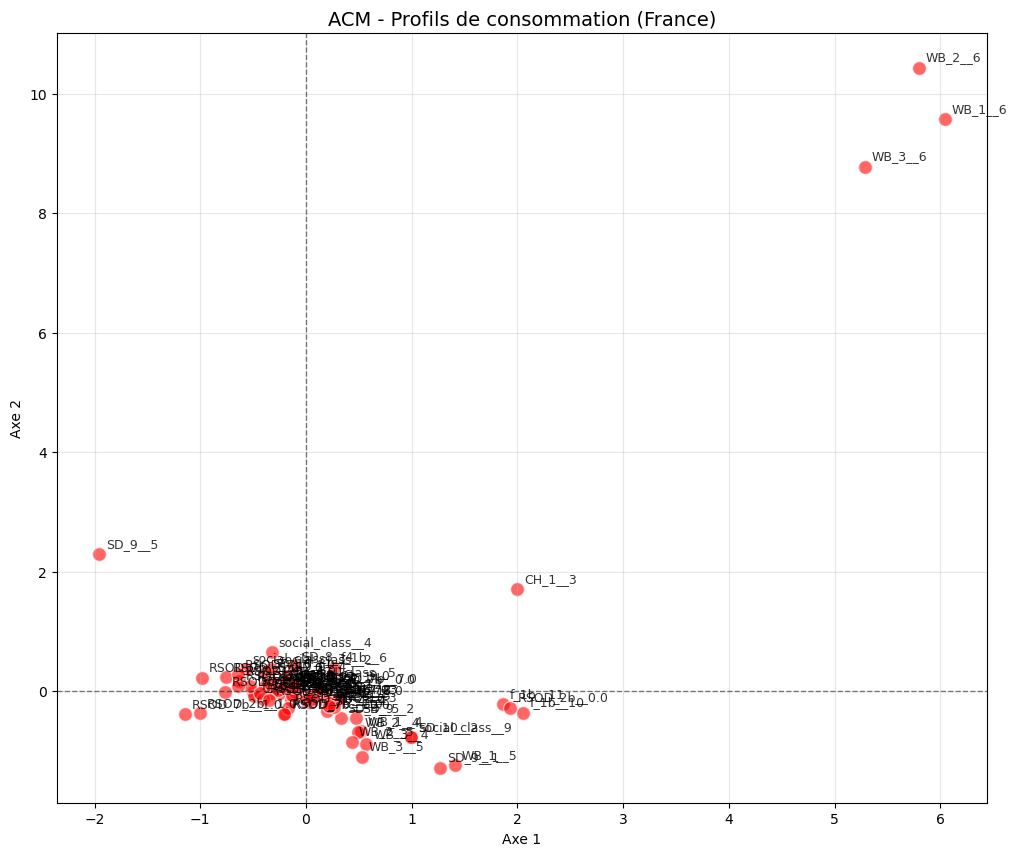

In [239]:
import Data_analysis as dtn

# 1. Liste de tes variables qualitatives (quali.columns que tu as défini)
# Assure-toi que COUNTRY n'est pas dedans pour éviter les erreurs
mes_vars_quali = [c for c in quali.columns if c != 'COUNTRY']

# 2. Calcul de l'ACM pour la France
acm_fr, df_input_fr = dtn.calculer_acm_pays(data, "France", mes_vars_quali)

# 3. Identification des profils types sur l'Axe 1
# En ACM, on regarde souvent les coordonnées les plus fortes pour voir les oppositions
individus_acm = dtn.identifier_individus_typiques_acm(acm_fr, df_input_fr, data, axe=0)

display(individus_acm)
# Utilisation de la nouvelle fonction de dessin manuelle
dtn.trace_acm_categories(acm_fr, df_input_fr, titre="ACM - Profils de consommation (France)")


In [240]:
#On recode certaines variables pour rendre l'ACM plus facilement interprétable

# Recodage du REVENU (sd_20month)
# On le découpe en quartiles
df_acm= data.copy()
df_acm['sd_20month'] = pd.qcut(df_acm['sd_20month'], q=4, labels=['Revenu_quartile1', 'Revenu_quartile2', 'Revenu_quartile3','Revenu_quartile4'])
df_acm['RSOD_2b'] = df_acm['RSOD_2b'].apply(dtn.simplifier_rsod)#recodage du binge drinking en 4 catégories (cf Data_analysis.py)
df_acm['f_1b'] = df_acm['f_1b'].apply(dtn.recoder_f1b)#recodage de la fréquence de consommation d'alcool en 4 catégories


Avant de faire l'ACM, on doit choisir les variables qui sont actives, c'est à dire qui participent à la construction des axes. Elles permettront alors de comprendre les liens entre les modalités (la plus ou moins forte consommation d'alcool ou le genre par exemple) et de repérer la prévalence de ces modalités pour des groupes d'individus par exemple. On fixe ce que l'on cherche : trouver des liens entre la consommation d'alcool et des caractéristiques intrinsèques des individus (socio-économique notamment). C'est donc les variables qui décrivent cela que l'on doit prendre comme variables actives. Ensuite, nous choisissons quelques variables illustratives pertinentes au vue de la littérature et des analyses descriptives précédentes (elles peuvent être qualitatives ou quantitatives - donc on peut y mettre la consommation d'alcool bsqf_alc notamment). Ces variables ne sont pas utilisées pour la construction des axes, mais sont projetées a posteriori sur les axes pour enrichir, si possible, l'interprétation. En suivant cette idée, on fait les choix suivant:

In [241]:
# Variables Actives
actives = [
    "sd_20month", "f_1b", "RSOD_2b", "SD_9", "SD_1", 
    "social_class", "WB_1", "WB_2", "WB_3",]
    
# Variables Illustratives
illustratives = [ "SD_2", "SD_6", "SD_8"," SD_7", "cbsqf","cbsqf_beer", "cbsqf_spir", "cbsqf_wine"]

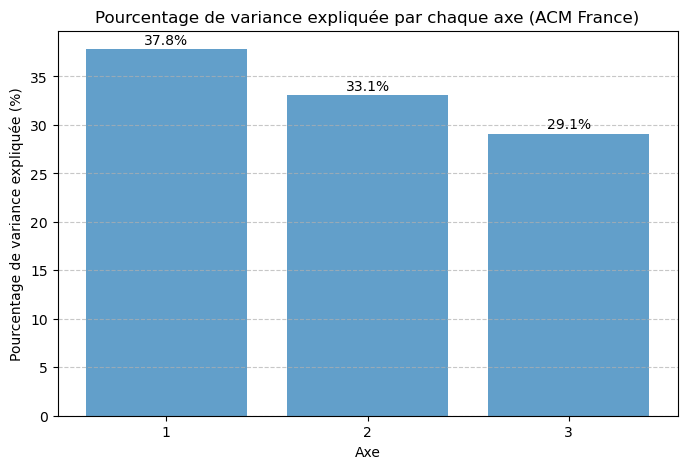

In [242]:
importlib.reload(dtn)

mca_fr = dtn.fait_acm(df_acm, "France", actives)
dtn.plot_var_acm(mca_fr, "France")

Comme le nombre de modalités est trop important pour être lisible en représantation graphique, on regarde plutôt pour commencer le lien entre chacune des deux premières dimensions et les variables actives.

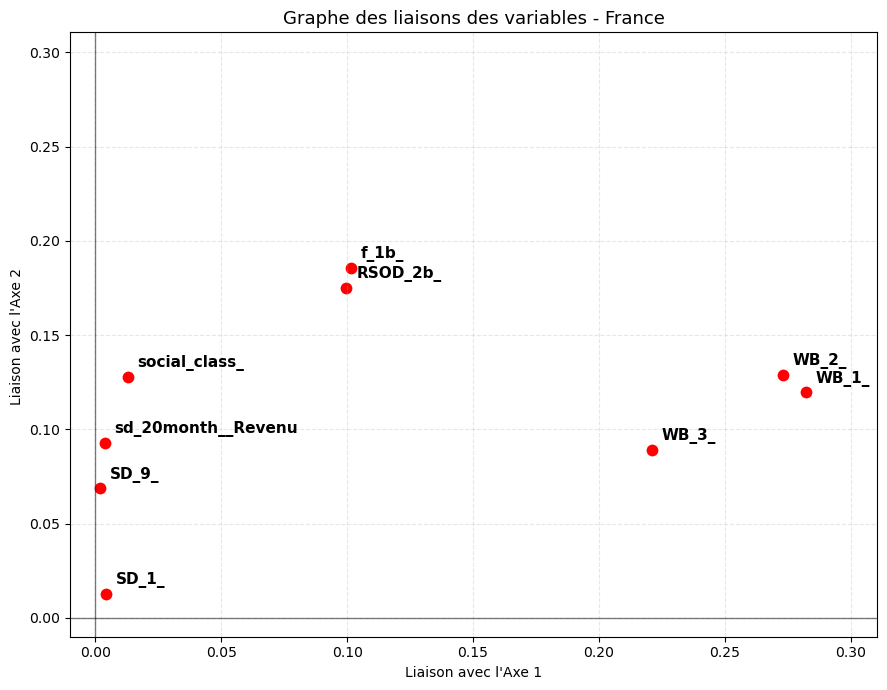

In [243]:
#graphe des contributions de chaque variables aux 2 premiers axes
dtn.tracer_graphe_liaisons(mca_fr, "France")

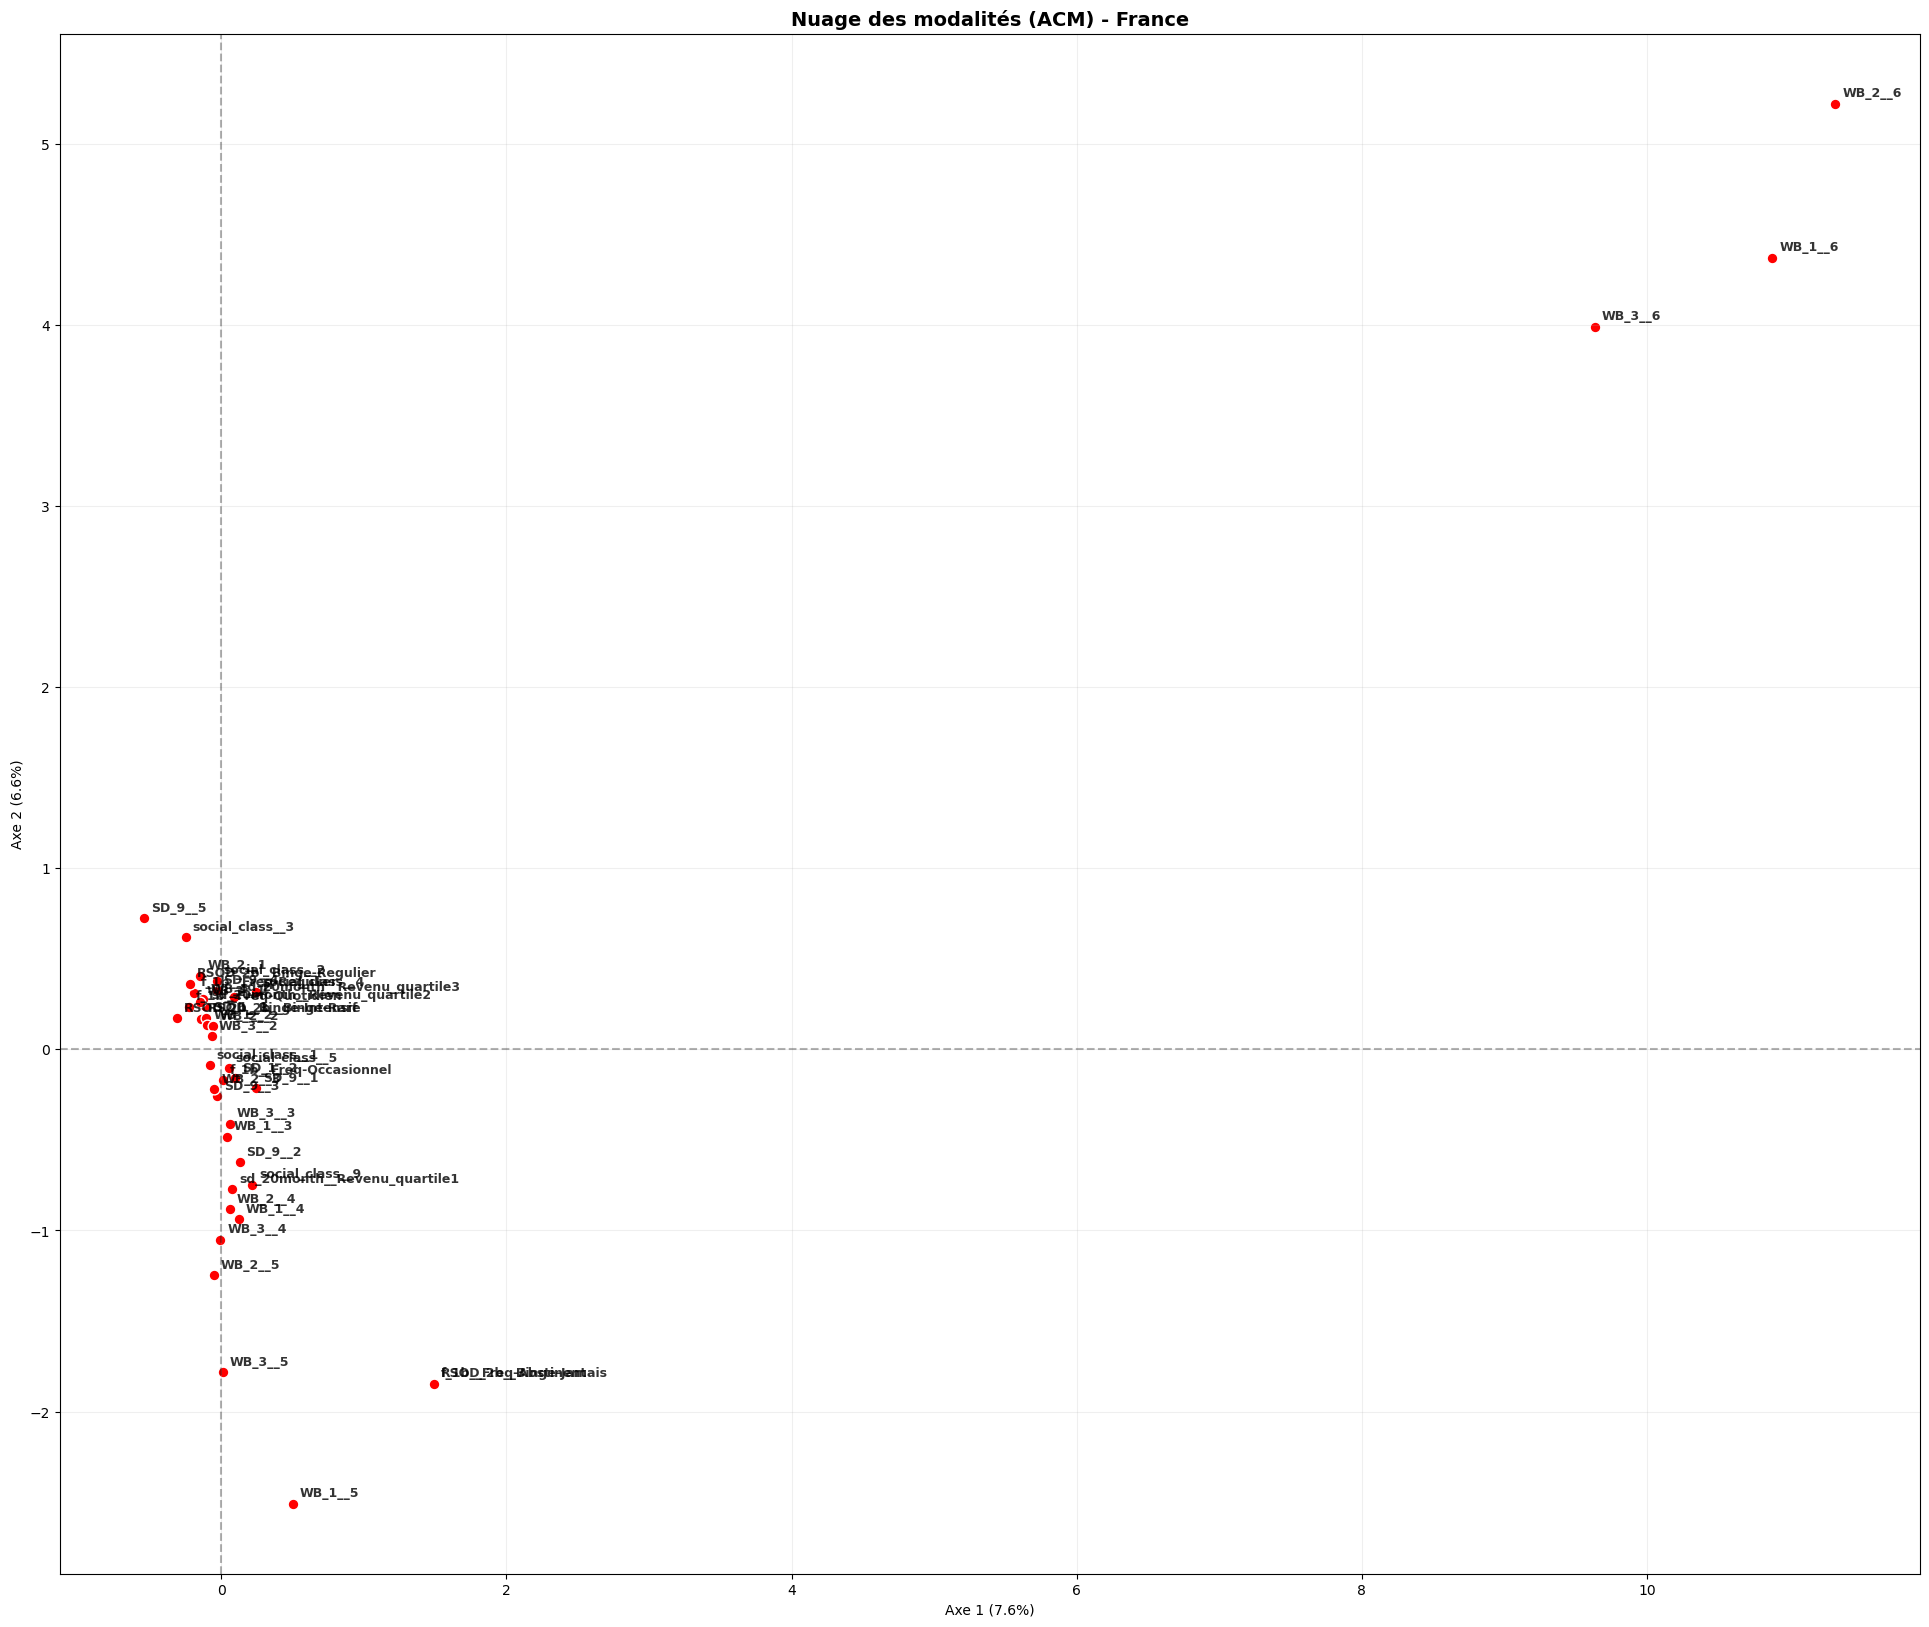

In [244]:
def plot_modalites_acm_simple(data,mca, vars_actives, pays_nom):
    """
    Trace le nuage des modalités proprement sans utiliser les fonctions 
    automatiques de prince qui buggent souvent.
    """
    # 1. Extraction des coordonnées des modalités (Colonnes)
    # Dans prince MCA, les modalités sont les "columns"
    coords = mca.column_coordinates(data[data['COUNTRY'] == pays_nom][vars_actives].astype(str))
    
    plt.figure(figsize=(24, 20))
    
    # 2. On trace chaque modalité
    plt.scatter(coords[0], coords[1], c='red', edgecolors='white', s=60)
    
    # 3. Ajout des étiquettes (labels)
    for i, txt in enumerate(coords.index):
        plt.annotate(txt, (coords.iloc[i, 0], coords.iloc[i, 1]), 
                     xytext=(5, 5), textcoords='offset points', 
                     fontsize=9, alpha=0.8, fontweight='bold')

    # 4. Esthétique de l'axe (Lignes à 0,0)
    plt.axhline(0, color='black', linestyle='--', alpha=0.3)
    plt.axvline(0, color='black', linestyle='--', alpha=0.3)
    
    plt.title(f'Nuage des modalités (ACM) - {pays_nom}', fontsize=14, fontweight='bold')
    plt.xlabel(f'Axe 1 ({mca.percentage_of_variance_[0]:.1f}%)')
    plt.ylabel(f'Axe 2 ({mca.percentage_of_variance_[1]:.1f}%)')
    plt.grid(True, alpha=0.2)
    
    plt.show()


plot_modalites_acm_simple(df_acm,mca_fr, actives, "France")


In [203]:
# Extraction des coordonnées des modalités
coords_modalites = mca_fr.column_coordinates(df_actives_fr)

# Affichage des positions pour les variables WB sur l'Axe 1 (colonne 0)
# On trie pour voir ce qui est le plus à droite et le plus à gauche
wb_coords = coords_modalites[coords_modalites.index.str.contains('WB_')]
print(wb_coords[0].sort_values())

WB_3__1    -0.151322
WB_2__1    -0.143674
WB_1__1    -0.119755
WB_2__5    -0.107176
WB_3__5    -0.106845
WB_1__2    -0.102265
WB_3__2    -0.070820
WB_2__2    -0.061038
WB_1__4    -0.044229
WB_2__3    -0.033309
WB_2__4     0.035559
WB_3__4     0.036994
WB_1__3     0.073282
WB_3__3     0.073353
WB_1__5     0.540733
WB_3__6     9.700330
WB_1__6    10.935461
WB_2__6    11.389709
Name: 0, dtype: float64


c:\Users\Utilisateur\Documents\Téléchargements\Anaconda\Lib\site-packages\prince\ca.py:222: RuntimeWarning: invalid value encountered in divide
  X = X.T / X.T.sum(axis=1)[:, None]


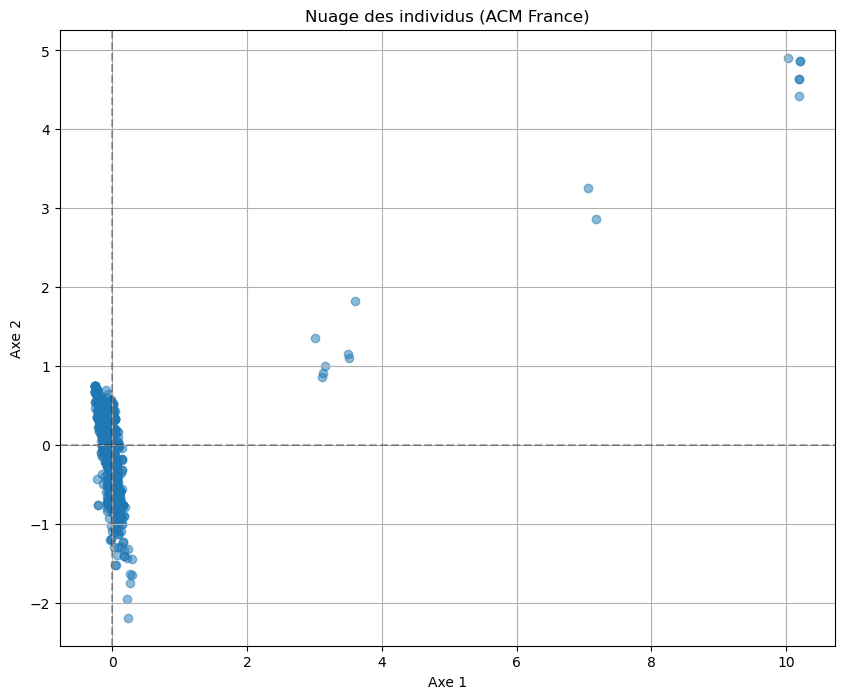

In [ ]:
# Nuage des individus dans le plan des deux premiers axes de l'ACM
dtn.plot_individus_acm(mca_fr, data, "France", actives)


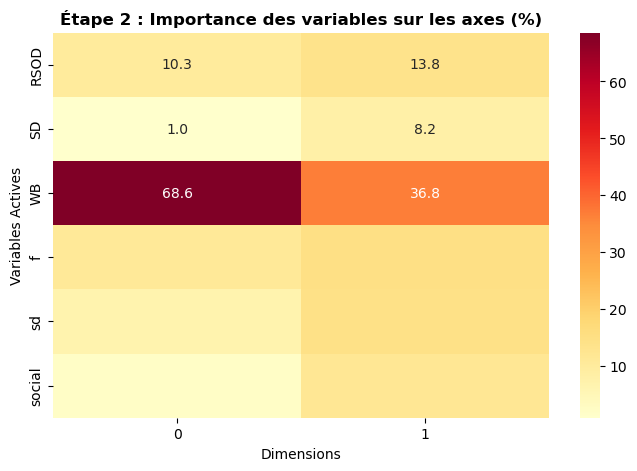

In [156]:
# 1. Extraire les contributions des modalités (déjà calculées par le modèle)
# Les contributions indiquent quel % de l'axe est expliqué par chaque modalité
contrib = mca_fr.column_contributions_

# 2. Grouper par variable pour avoir une vision globale
# On additionne les contributions de toutes les modalités d'une même variable
liaison = contrib.copy()
liaison['Variable'] = [c.split('_')[0] for c in liaison.index]
resultat = liaison.groupby('Variable').sum() * 100 # Passage en %

# 3. Affichage du Heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(resultat[[0, 1]], annot=True, cmap="YlOrRd", fmt=".1f")

plt.title("Étape 2 : Importance des variables sur les axes (%)", fontweight='bold')
plt.xlabel("Dimensions")
plt.ylabel("Variables Actives")
plt.show()

AttributeError: module 'matplotlib.pyplot' has no attribute 'add_artist'

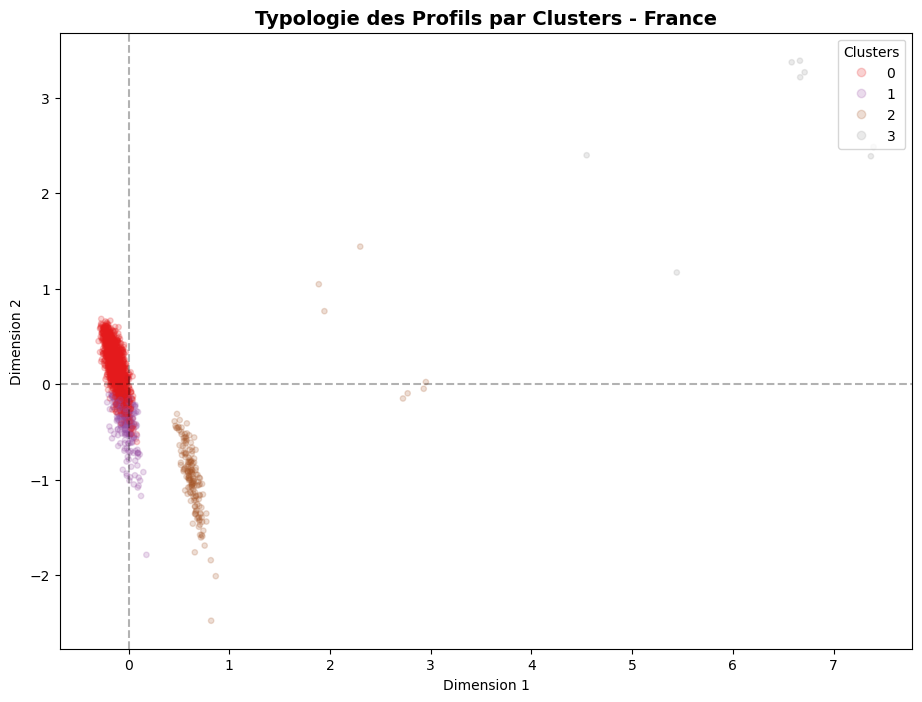

In [248]:
from sklearn.cluster import AgglomerativeClustering

def etape_4_classification_robuste(mca, df_source, vars_actives, pays_nom, n_clusters=4):
    """
    Classification sur les composantes de l'ACM.
    On récupère les coordonnées des individus par projection directe.
    """
    # 1. Extraction des données correspondantes au modèle
    subset = df_source[df_source['COUNTRY'] == pays_nom].copy()
    df_input = subset[vars_actives].astype(str)
    
    # 2. Récupération des coordonnées (les "composantes")
    # On utilise la méthode row_coordinates sur les données filtrées
    ind_coords = mca.row_coordinates(df_input)
    
    # 3. Application de la CAH (ou KMeans si c'est trop lent)
    # Note : AgglomerativeClustering est très gourmand en RAM
    cluster = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    labels = cluster.fit_predict(ind_coords)
    
    return labels

# --- EXÉCUTION ---
# On utilise bien df_acm qui contient tes recodages (quartiles, etc.)
labels_clusters = etape_4_classification_robuste(mca_fr, df_acm, actives, "France", n_clusters=4)

# Assignation des labels au bon endroit dans le DataFrame
mask = df_acm['COUNTRY'] == 'France'
df_acm.loc[mask, 'Cluster'] = labels_clusters
def plot_nuage_clusters_robuste(mca, df_source, vars_actives, labels, pays_nom):
    """
    Visualisation du nuage des individus coloré par clusters.
    Utilise df_source pour recalculer les coordonnées nécessaires.
    """
    # 1. Extraction des données et calcul des coordonnées
    subset = df_source[df_source['COUNTRY'] == pays_nom].copy()
    df_input = subset[vars_actives].astype(str)
    coords = mca.row_coordinates(df_input)
    
    plt.figure(figsize=(11, 8))
    
    # 2. Tracé avec coloration par cluster
    # On ajoute un léger jitter pour voir la masse des individus (alpha=0.2)
    import numpy as np
    x = coords[0] + np.random.normal(0, 0.02, size=len(coords))
    y = coords[1] + np.random.normal(0, 0.02, size=len(coords))
    
    scatter = plt.scatter(x, y, c=labels, cmap='Set1', alpha=0.2, s=15)
    
    # 3. Esthétique
    plt.axhline(0, color='black', linestyle='--', alpha=0.3)
    plt.axvline(0, color='black', linestyle='--', alpha=0.3)
    
    plt.title(f"Typologie des Profils par Clusters - {pays_nom}", fontsize=14, fontweight='bold')
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    
    # Ajout d'une légende pour les clusters
    legend = plt.legend(*scatter.legend_elements(), title="Clusters", loc="upper right")
    plt.add_artist(legend)
    
    plt.grid(True, alpha=0.1)
    plt.show()

# --- UTILISATION ---
plot_nuage_clusters_robuste(mca_fr, df_acm, actives, labels_clusters, "France")
plot_nuage_clusters(mca_fr, labels_clusters, "France")

**Annexes**

Annexes Partie II

In [ ]:
print("matrice des corrélations ACP France")
matrice_fr = dtn.obtenir_matrice_pca(data, "France", quanti.columns)
matrice_fr


matrice des corrélations ACP France


,SD_2,SD_7,sd_20month,bsqf_alc,cbsqf_beer,cbsqf_spir,cbsqf_wine
SD_2,1.000596,-0.177751,-0.037964,-0.043799,-0.081333,-0.058563,0.062788
SD_7,-0.177751,1.000596,-0.027796,0.048047,0.050830,0.033375,0.024506
sd_20month,-0.037964,-0.027796,1.000596,-0.048944,-0.060759,0.008808,-0.052781
bsqf_alc,-0.043799,0.048047,-0.048944,1.000596,0.881673,0.700625,0.667198
cbsqf_beer,-0.081333,0.050830,-0.060759,0.881673,1.000596,0.463107,0.387182
cbsqf_spir,-0.058563,0.033375,0.008808,0.700625,0.463107,1.000596,0.342601
cbsqf_wine,0.062788,0.024506,-0.052781,0.667198,0.387182,0.342601,1.000596


In [ ]:
print("matrice des corrélations ACP Bulgarie")
matrice_bg = dtn.obtenir_matrice_pca(data, "Bulgaria", quanti.columns)
matrice_bg

matrice des corrélations ACP Bulgarie


,SD_2,SD_7,sd_20month,bsqf_alc,cbsqf_beer,cbsqf_spir,cbsqf_wine
SD_2,1.000334,-0.144816,-0.023961,-0.013679,-0.004385,0.063876,-0.012236
SD_7,-0.144816,1.000334,-0.015405,0.010646,0.018388,-0.009748,-0.006044
sd_20month,-0.023961,-0.015405,1.000334,-0.033574,-0.076749,-0.029575,-0.023386
bsqf_alc,-0.013679,0.010646,-0.033574,1.000334,0.185589,0.059917,0.064783
cbsqf_beer,-0.004385,0.018388,-0.076749,0.185589,1.000334,0.252698,0.238649
cbsqf_spir,0.063876,-0.009748,-0.029575,0.059917,0.252698,1.000334,0.165742
cbsqf_wine,-0.012236,-0.006044,-0.023386,0.064783,0.238649,0.165742,1.000334


In [ ]:
print("matrice des corrélations ACP Pologne")
matrice_Pl = dtn.obtenir_matrice_pca(data, "Poland", quanti.columns)
matrice_Pl

matrice des corrélations ACP Pologne


,SD_2,SD_7,sd_20month,bsqf_alc,cbsqf_beer,cbsqf_spir,cbsqf_wine
SD_2,1.000642,-0.177022,-0.061103,-0.007241,0.013528,-0.004672,-0.048204
SD_7,-0.177022,1.000642,0.011201,0.084950,0.079115,0.080388,0.102991
sd_20month,-0.061103,0.011201,1.000642,0.035953,-0.046598,-0.022333,-0.019646
bsqf_alc,-0.007241,0.084950,0.035953,1.000642,0.115154,0.194679,0.133516
cbsqf_beer,0.013528,0.079115,-0.046598,0.115154,1.000642,0.414116,0.449896
cbsqf_spir,-0.004672,0.080388,-0.022333,0.194679,0.414116,1.000642,0.430644
cbsqf_wine,-0.048204,0.102991,-0.019646,0.133516,0.449896,0.430644,1.000642


In [ ]:
print("matrice des corrélations ACP Islande")
matrice_Ic = dtn.obtenir_matrice_pca(data, "Iceland", quanti.columns)
matrice_Ic

matrice des corrélations ACP Islande


,SD_2,SD_7,sd_20month,bsqf_alc,cbsqf_beer,cbsqf_spir,cbsqf_wine
SD_2,1.000693,-0.052848,0.040516,-0.017617,-0.043122,-0.034362,0.056520
SD_7,-0.052848,1.000693,-0.004408,-0.004546,-0.020647,0.017748,0.008003
sd_20month,0.040516,-0.004408,1.000693,-0.132353,-0.144057,-0.058605,-0.065214
bsqf_alc,-0.017617,-0.004546,-0.132353,1.000693,0.783077,0.589530,0.546695
cbsqf_beer,-0.043122,-0.020647,-0.144057,0.783077,1.000693,0.241610,0.122356
cbsqf_spir,-0.034362,0.017748,-0.058605,0.589530,0.241610,1.000693,0.099296
cbsqf_wine,0.056520,0.008003,-0.065214,0.546695,0.122356,0.099296,1.000693
